# Training

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score,
    matthews_corrcoef, confusion_matrix, accuracy_score, precision_score, recall_score, auc
)
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc as calculate_auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
import shap
# Ignore warnings for clean output
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define file paths
file_path = "C:/Users/ghaza/Desktop/FYP/Application/AI/data/processed/"

# Load datasets
X_train_balanced_binary = pd.read_csv(file_path + "balanced_X_train_binary.csv")
y_train_balanced_binary = pd.read_csv(file_path + "balanced_y_train_binary.csv").squeeze()  # Convert to Series
X_test = pd.read_csv(file_path + "X_test.csv")
y_test_binary = pd.read_csv(file_path + "y_test_binary.csv").squeeze()  # Convert to Series

# Verify loaded data
print("Datasets Loaded:")
print(f"X_train_balanced_binary: {X_train_balanced_binary.shape}")
print(f"y_train_balanced_binary: {y_train_balanced_binary.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test_binary: {y_test_binary.shape}")

Datasets Loaded:
X_train_balanced_binary: (146200, 7)
y_train_balanced_binary: (146200,)
X_test: (52487, 7)
y_test_binary: (52487,)


In [4]:
# Check if y_train is a DataFrame with a single column and convert to 1D array if needed
if isinstance(y_train_balanced_binary, pd.DataFrame) and y_train_balanced_binary.shape[1] == 1:
    y_train_balanced_binary = y_train_balanced_binary.values.ravel()

# Similarly for y_test
if isinstance(y_test_binary, pd.DataFrame) and y_test_binary.shape[1] == 1:
    y_test_binary = y_test_binary.values.ravel()

# Alternatively, if y_train or y_test are numpy arrays, you can check their number of dimensions:
if isinstance(y_train_balanced_binary, np.ndarray) and y_train_balanced_binary.ndim > 1:
    y_train_balanced_binary = y_train_balanced_binary.ravel()
if isinstance(y_test_binary, np.ndarray) and y_test_binary.ndim > 1:
    y_test_binary = y_test_binary.ravel()

In [5]:
# Initialize dictionary to store results
binary_classification_results = {}

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                          random_state=42, max_iter=300)
}

In [6]:
# Iterate through models
for model_name, model in models.items():
    print(f"\nTraining {model_name}")
    
    # Train model
    model.fit(X_train_balanced_binary, y_train_balanced_binary)
    
    # Predict on training set
    y_train_pred = model.predict(X_train_balanced_binary)
    
    # Predict on testing set
    y_test_pred = model.predict(X_test)
    
    # Calculate probabilities for AUC-PR and AUC-ROC
    y_test_probs = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    if y_test_probs is not None:
        precision, recall, _ = precision_recall_curve(y_test_binary, y_test_probs)
        auc_pr = auc(recall, precision)  # Correctly calculate Precision-Recall AUC
        auc_roc = roc_auc_score(y_test_binary, y_test_probs)
    else:
        auc_pr = None
        auc_roc = None
    
    # Evaluate train and test accuracy
    train_accuracy = accuracy_score(y_train_balanced_binary, y_train_pred)
    test_accuracy = accuracy_score(y_test_binary, y_test_pred)

    # Print results
    print(f"\nTrain Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_binary, y_test_pred))
    
    # Additional Metrics
    f1 = f1_score(y_test_binary, y_test_pred)
    mcc = matthews_corrcoef(y_test_binary, y_test_pred)
    cm = confusion_matrix(y_test_binary, y_test_pred)
    specificity = cm[0, 0] / sum(cm[0])  # TN / (TN + FP)
    precision_score_metric = precision_score(y_test_binary, y_test_pred)
    recall_score_metric = recall_score(y_test_binary, y_test_pred)

    # Store results
    binary_classification_results[model_name] = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "F1-Score": f1,
        "AUC-PR": auc_pr,
        "AUC-ROC": auc_roc,
        "MCC": mcc,
        "Specificity": specificity,
        "Precision": precision_score_metric,
        "Recall": recall_score_metric
    }


Training Decision Tree

Train Accuracy: 1.0000
Test Accuracy: 0.8616

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     38015
           1       0.70      0.86      0.77     14472

    accuracy                           0.86     52487
   macro avg       0.82      0.86      0.84     52487
weighted avg       0.88      0.86      0.87     52487


Training Random Forest

Train Accuracy: 1.0000
Test Accuracy: 0.8856

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     38015
           1       0.75      0.88      0.81     14472

    accuracy                           0.89     52487
   macro avg       0.85      0.88      0.86     52487
weighted avg       0.90      0.89      0.89     52487


Training Gradient Boosting

Train Accuracy: 0.9509
Test Accuracy: 0.8701

Classification Report:
              precision    recall  f1-score   support

     

In [7]:
# Convert results to DataFrame
binary_results_df = pd.DataFrame(binary_classification_results).T
print("\nSummary of Results:")
print(binary_results_df)


Summary of Results:
                     Train Accuracy  Test Accuracy  F1-Score    AUC-PR  \
Decision Tree              1.000000       0.861566  0.774865  0.801951   
Random Forest              1.000000       0.885553  0.809053  0.897474   
Gradient Boosting          0.950896       0.870101  0.792248  0.909571   
Logistic Regression        0.918570       0.838893  0.749452  0.873575   
k-NN                       0.994316       0.859527  0.774492  0.851425   
MLP                        0.953085       0.882238  0.805488  0.917365   

                      AUC-ROC       MCC  Specificity  Precision    Recall  
Decision Tree        0.862324  0.684011     0.860634   0.702393  0.864013  
Random Forest        0.948682  0.732850     0.887913   0.749161  0.879353  
Gradient Boosting    0.952779  0.710078     0.859371   0.708601  0.898286  
Logistic Regression  0.930020  0.648407     0.825569   0.656033  0.873894  
k-NN                 0.911002  0.683869     0.853689   0.694781  0.874862  
MLP 

In [8]:
def add_data_labels(ax, rects):
    """
    Adds data labels on top of each bar in a bar chart.
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.0,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="black",
        )

def plot_model_metrics(results_df):
    """
    Given a results DataFrame, this function plots:
      - Train vs Test Accuracy (grouped bar chart)
      - F1-Score (bar chart)
      - AUC-PR (bar chart)
      - AUC-ROC (bar chart)
      
    Light color themes are used and data labels are added.
    """
    # Define consistent color theme for the charts:
    colors = {
        "Train Accuracy": "lightcoral",
        "Test Accuracy": "lightsalmon",
        "F1-Score": "skyblue",
        "AUC-PR": "lightpink",
        "AUC-ROC": "lightgreen"
    }
    
    # ---------------- Train vs Test Accuracy ----------------
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    indices = np.arange(len(results_df))
    width = 0.35
    train_bar = ax.bar(indices - width/2, results_df["Train Accuracy"], width, 
                       label="Train Accuracy", color=colors["Train Accuracy"], alpha=0.8)
    test_bar = ax.bar(indices + width/2, results_df["Test Accuracy"], width, 
                      label="Test Accuracy", color=colors["Test Accuracy"], alpha=0.8)
    add_data_labels(ax, train_bar)
    add_data_labels(ax, test_bar)
    ax.set_title("Train vs Test Accuracy for Models")
    ax.set_ylabel("Accuracy")
    ax.set_xticks(indices)
    ax.set_xticklabels(results_df.index, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # ---------------- F1-Score ----------------
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    f1_bar = ax.bar(results_df.index, results_df["F1-Score"], color=colors["F1-Score"], alpha=0.8)
    add_data_labels(ax, f1_bar)
    ax.set_title("F1-Score for Models")
    ax.set_ylabel("F1-Score")
    ax.set_xticklabels(results_df.index, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # ---------------- AUC-PR ----------------
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    auc_pr_bar = ax.bar(results_df.index, results_df["AUC-PR"], color=colors["AUC-PR"], alpha=0.8)
    add_data_labels(ax, auc_pr_bar)
    ax.set_title("AUC-PR for Models")
    ax.set_ylabel("AUC-PR")
    ax.set_xticklabels(results_df.index, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # ---------------- AUC-ROC ----------------
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    auc_roc_bar = ax.bar(results_df.index, results_df["AUC-ROC"], color=colors["AUC-ROC"], alpha=0.8)
    add_data_labels(ax, auc_roc_bar)
    ax.set_title("AUC-ROC for Models")
    ax.set_ylabel("AUC-ROC")
    ax.set_xticklabels(results_df.index, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

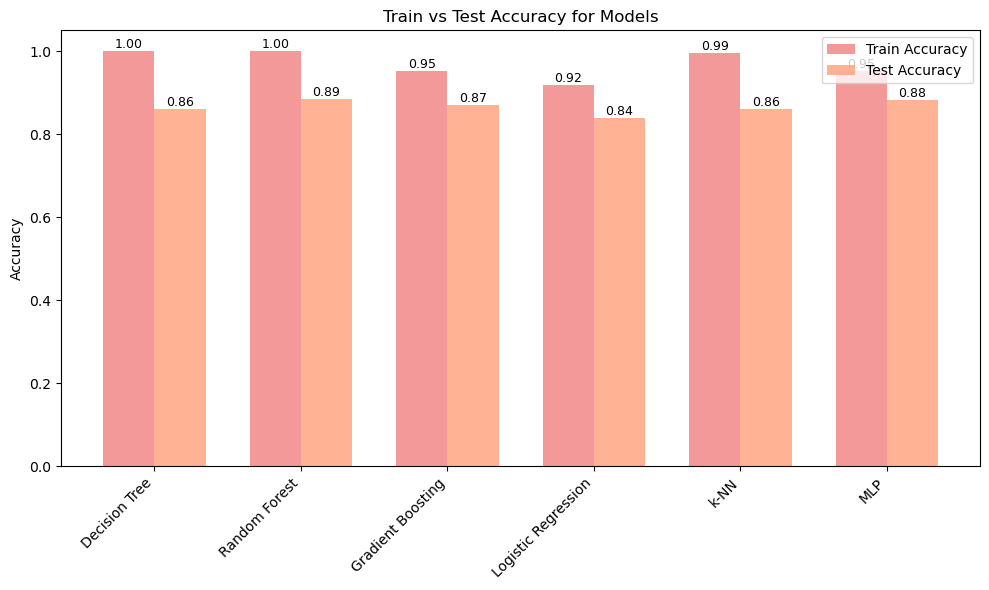

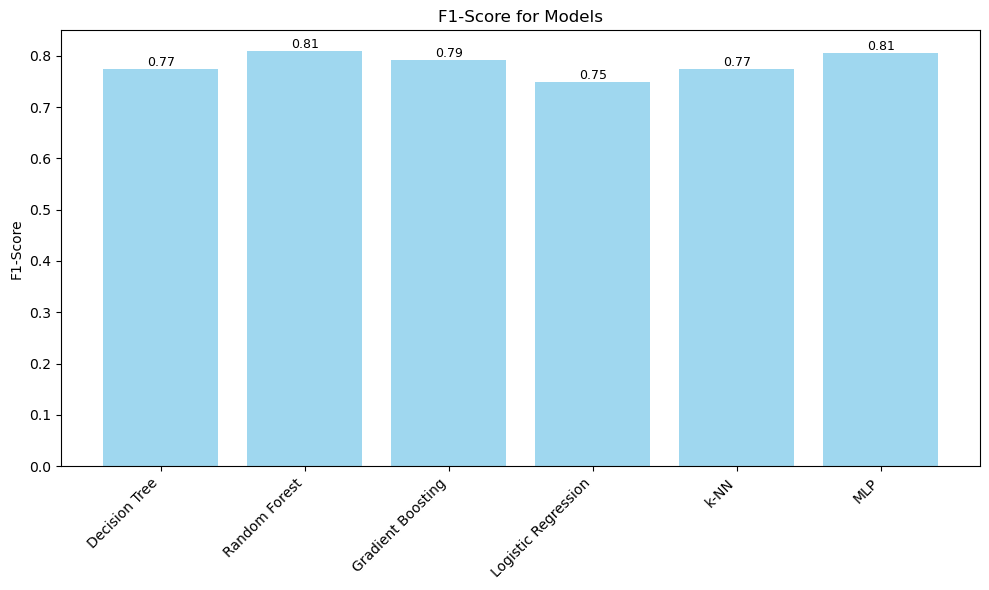

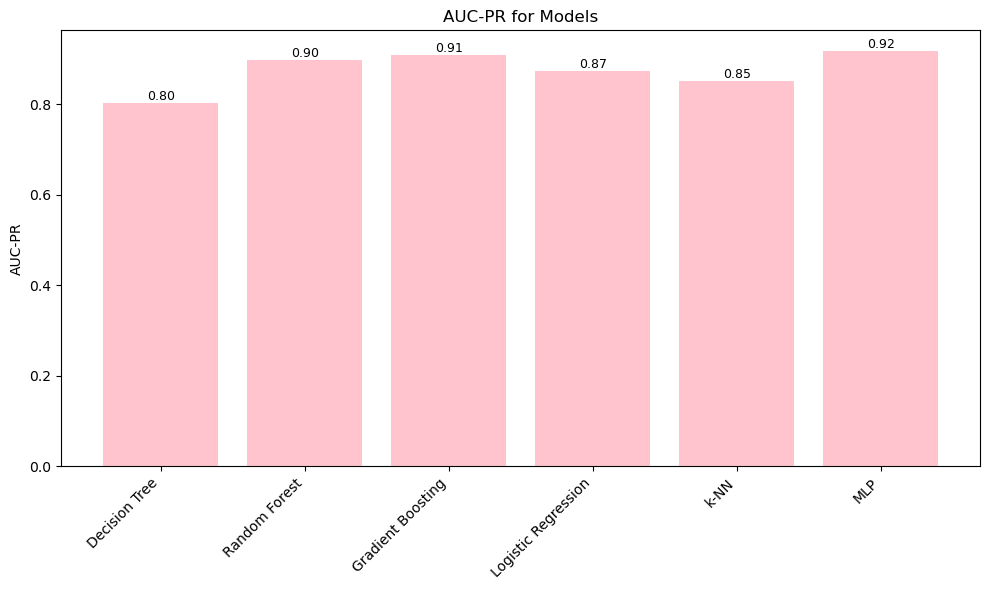

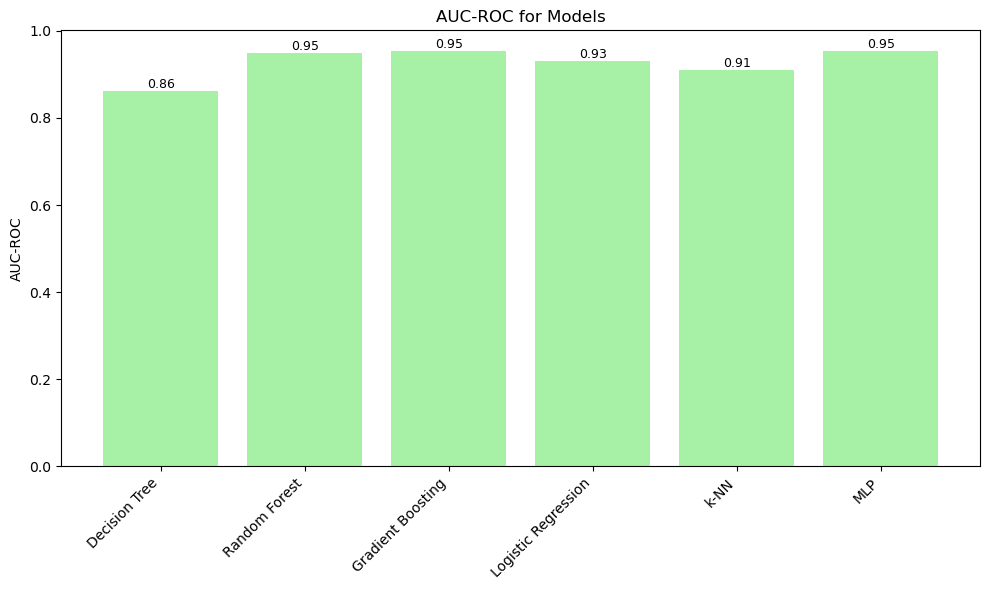

In [9]:
plot_model_metrics(binary_results_df)

In [10]:
# Define parameter grids for each model
param_grid_dt = {"max_depth": [None, 5, 10, 20], "min_samples_split": [2, 5, 10]}
param_grid_rf = {"n_estimators": [50, 100, 200], "max_depth": [None, 5, 10], "min_samples_split": [2, 5]}
param_grid_gb = {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}
param_grid_lr = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["liblinear"]}
param_grid_knn = {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
param_grid_mlp = {"hidden_layer_sizes": [(100,), (100, 50)], "activation": ["relu", "tanh"],
                  "learning_rate_init": [0.001, 0.01], "solver": ["adam"]}

In [11]:
models_with_grids = {
    "Decision Tree": {"model": models["Decision Tree"], "param_grid": param_grid_dt},
    "Random Forest": {"model": models["Random Forest"], "param_grid": param_grid_rf},
    "Gradient Boosting": {"model": models["Gradient Boosting"], "param_grid": param_grid_gb},
    "Logistic Regression": {"model": models["Logistic Regression"], "param_grid": param_grid_lr},
    "k-NN": {"model": models["k-NN"], "param_grid": param_grid_knn},
    "MLP": {"model": models["MLP"], "param_grid": param_grid_mlp}
}

In [12]:
def run_grid_search(X_train, y_train, X_test, y_test, models_with_grids, cv_strategy, scoring="f1"):
    grid_search_results = {}
    trained_models = {}
    threshold = 0.1  # 10% gap for over/under-fitting check
    
    def check_over_under(train_acc, test_acc):
        if train_acc > test_acc + threshold:
            return "Potential Overfitting Detected!"
        elif test_acc > train_acc + threshold:
            return "Potential Underfitting Detected!"
        else:
            return "Balanced Performance"
    
    for model_name, model_data in models_with_grids.items():
        print(f"\nRunning Grid Search for {model_name}...", flush=True)
        model = model_data["model"]
        param_grid = model_data["param_grid"]
    
        grid_search = GridSearchCV(estimator=model,
                                   param_grid=param_grid,
                                   scoring=scoring,
                                   cv=cv_strategy,
                                   verbose=2,
                                   n_jobs=-1)
        grid_search.fit(X_train, y_train)
    
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best Parameters for {model_name}: {best_params}", flush=True)
    
        trained_models[model_name] = best_model
    
        y_train_pred = best_model.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)
    
        y_test_pred = best_model.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
    
        fit_status = check_over_under(train_acc, test_acc)
        print(f"Train Accuracy: {train_acc:.4f}", flush=True)
        print(f"Test Accuracy: {test_acc:.4f}", flush=True)
        print(fit_status, flush=True)
    
        f1 = f1_score(y_test, y_test_pred)
        mcc = matthews_corrcoef(y_test, y_test_pred)
        cm = confusion_matrix(y_test, y_test_pred)
        specificity = cm[0, 0] / np.sum(cm[0])
    
        if hasattr(best_model, "predict_proba"):
            y_test_probs = best_model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
            auc_pr = auc(recall, precision)
            auc_roc = roc_auc_score(y_test, y_test_probs)
        else:
            auc_pr = None
            auc_roc = None
    
        print(f"\nClassification Report for {model_name}:", flush=True)
        print(classification_report(y_test, y_test_pred), flush=True)
    
        grid_search_results[model_name] = {
            "Best Parameters": best_params,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "F1-Score": f1,
            "AUC-PR": auc_pr,
            "AUC-ROC": auc_roc,
            "MCC": mcc,
            "Specificity": specificity,
            "Fit Status": fit_status
        }
        
        # Print out the results immediately for each model.
        print(f"Results for {model_name}: {grid_search_results[model_name]}", flush=True)
    
    results_df = pd.DataFrame(grid_search_results).T
    print("\nSummary of Results:", flush=True)
    print(results_df, flush=True)
    return trained_models, grid_search_results, results_df

In [13]:
# ----------------------- Anomaly Detection -----------------------
def run_anomaly_detection(X_train, X_test, n_estimators=100, contamination=0.05, random_state=42):
    iso = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    iso.fit(X_train)
    anomaly_predictions = iso.predict(X_test)  # 1 indicates normal, -1 indicates anomaly
    num_anomalies = np.sum(anomaly_predictions == -1)
    print(f"\nIsolationForest: Number of anomalies in test set: {num_anomalies}")
    return iso, anomaly_predictions

In [14]:
def main_pipeline_from_data(X_train, y_train, X_test, y_test, models_with_grids):
   
    # Define CV strategy for imbalanced data
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Run Grid Search Training
    trained_models, grid_search_results, results_df = run_grid_search(
        X_train, y_train, X_test, y_test, models_with_grids, cv_strategy
    )
    
    # Run Anomaly Detection
    anomaly_model, anomaly_predictions = run_anomaly_detection(X_train, X_test)
    
    # Return all relevant objects for later use
    return {
        "trained_models": trained_models,
        "grid_search_results": grid_search_results,
        "results_df": results_df,
        "anomaly_model": anomaly_model,
        "anomaly_predictions": anomaly_predictions,
        "cv_strategy": cv_strategy,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

In [15]:
pipeline_results = main_pipeline_from_data(
    X_train_balanced_binary, y_train_balanced_binary, X_test, y_test_binary,
    models_with_grids
)


Running Grid Search for Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Decision Tree: {'max_depth': 20, 'min_samples_split': 2}
Train Accuracy: 0.9915
Test Accuracy: 0.8688
Potential Overfitting Detected!

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     38015
           1       0.72      0.86      0.78     14472

    accuracy                           0.87     52487
   macro avg       0.83      0.87      0.84     52487
weighted avg       0.88      0.87      0.87     52487

Results for Decision Tree: {'Best Parameters': {'max_depth': 20, 'min_samples_split': 2}, 'Train Accuracy': 0.9915321477428181, 'Test Accuracy': 0.8687675043344066, 'F1-Score': 0.7836955156387388, 'AUC-PR': 0.8074978089918761, 'AUC-ROC': 0.8713623942630657, 'MCC': 0.6965585742692734, 'Specificity': 0.8712613442062344, 'Fit Status': 'Potential Overfitting Detected!'}

Runn

In [16]:
# Choose a larger random subset from X_test for SHAP computation
n_samples = 100  # adjust this number as needed
X_test_sample = X_test.sample(n_samples, random_state=42)

# Expected number of features from your training set
expected_features = X_train_balanced_binary.shape[1]

# Compute main-effect SHAP values consistently across models
shap_explainers = {}
shap_values_main = {}

# Use a common background sample from the training data for KernelExplainer
background = shap.sample(X_train_balanced_binary, 100)

for model_name, model in pipeline_results["trained_models"].items():
    print(f"\nCreating main-effect SHAP explainer for {model_name}")
    if model_name in ["Decision Tree", "Random Forest", "Gradient Boosting"]:
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer.shap_values(X_test_sample)
    else:
        if hasattr(model, "predict_proba"):
            explainer = shap.KernelExplainer(model.predict_proba, background)
        else:
            explainer = shap.KernelExplainer(model.predict, background)
        shap_vals = explainer.shap_values(X_test_sample)
    
    # If shap_vals is a list (e.g., for binary classification using predict_proba), select the positive class (index 1)
    if isinstance(shap_vals, list):
        if len(shap_vals) == 2:
            shap_vals = shap_vals[1]
        else:
            shap_vals = shap_vals[0]
    
    # If the SHAP values array is 3D, check its third dimension.
    if shap_vals.ndim == 3:
        if shap_vals.shape[2] == 2:
            shap_vals_main_effect = shap_vals[:, :, 1]
        else:
            shap_vals_main_effect = np.array([np.diag(x) for x in shap_vals])
    else:
        shap_vals_main_effect = shap_vals

    print(f"SHAP values shape for {model_name}: {shap_vals_main_effect.shape}")
    if shap_vals_main_effect.shape[1] != expected_features:
        print(f"Warning: For {model_name}, expected {expected_features} features, but got {shap_vals_main_effect.shape[1]} columns.")
    
    shap_explainers[model_name] = explainer
    shap_values_main[model_name] = shap_vals_main_effect


Creating main-effect SHAP explainer for Decision Tree
SHAP values shape for Decision Tree: (100, 7)

Creating main-effect SHAP explainer for Random Forest
SHAP values shape for Random Forest: (100, 7)

Creating main-effect SHAP explainer for Gradient Boosting
SHAP values shape for Gradient Boosting: (100, 7)

Creating main-effect SHAP explainer for Logistic Regression


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP values shape for Logistic Regression: (100, 7)

Creating main-effect SHAP explainer for k-NN


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP values shape for k-NN: (100, 7)

Creating main-effect SHAP explainer for MLP


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP values shape for MLP: (100, 7)



Plotting main-effect SHAP summary plot for Decision Tree:


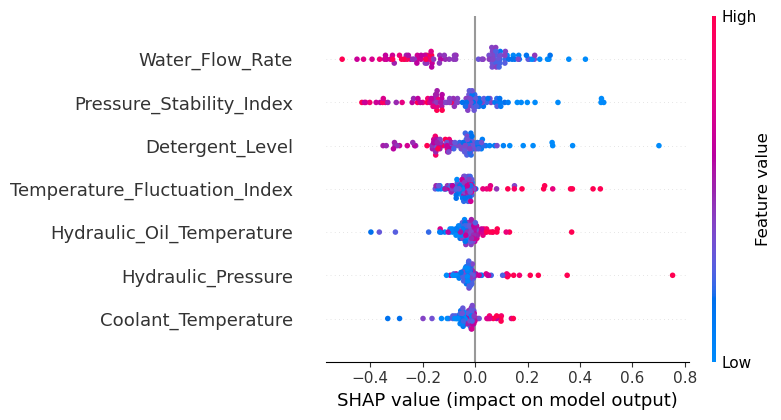


Plotting main-effect SHAP summary plot for Random Forest:


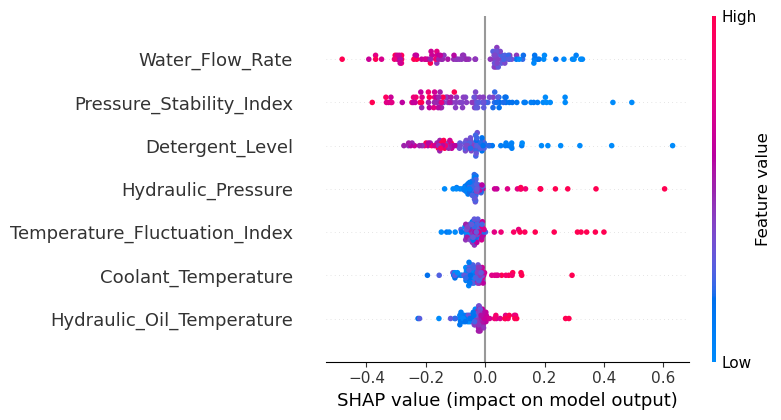


Plotting main-effect SHAP summary plot for Gradient Boosting:


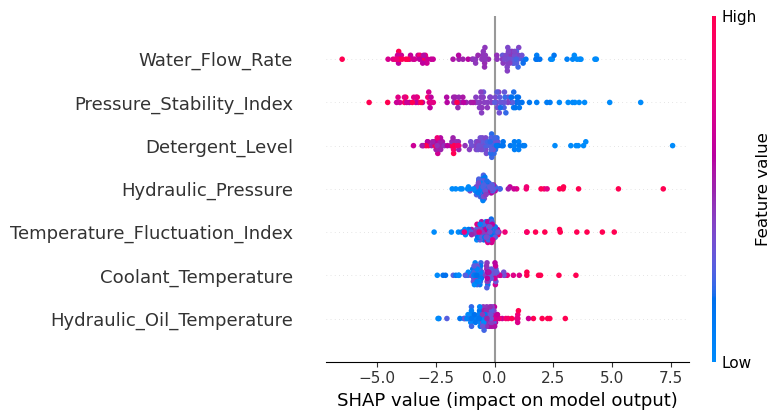


Plotting main-effect SHAP summary plot for Logistic Regression:


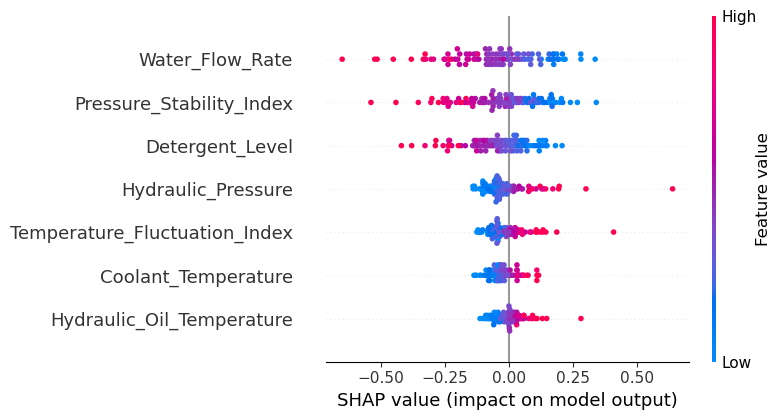


Plotting main-effect SHAP summary plot for k-NN:


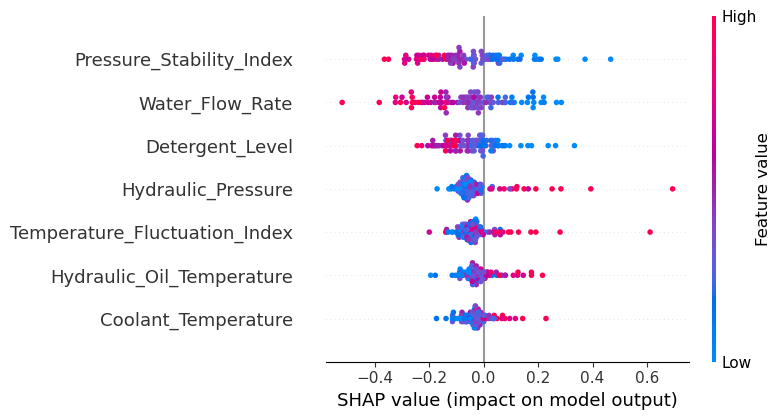


Plotting main-effect SHAP summary plot for MLP:


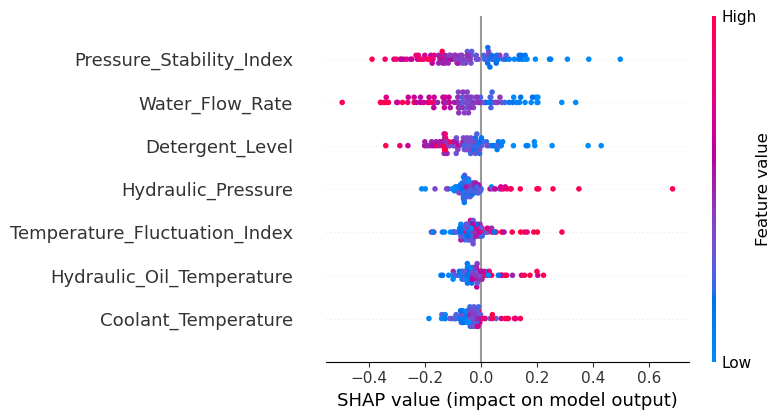

In [17]:
# Plot SHAP summary plots for main effects for each model using the larger subset
for model_name, shap_vals in shap_values_main.items():
    print(f"\nPlotting main-effect SHAP summary plot for {model_name}:")
    shap.summary_plot(shap_vals, X_test_sample, feature_names=X_train_balanced_binary.columns, plot_type="dot")

In [18]:
# Create a dictionary to hold aggregated SHAP values per model
aggregated_shap = {}

# For each model, compute the mean absolute SHAP value per feature
for model_name, shap_val in shap_values_main.items():
    # Compute the mean absolute value for each feature over the samples
    mean_abs_shap = np.abs(shap_val).mean(axis=0)
    aggregated_shap[model_name] = mean_abs_shap

# Create a DataFrame where rows are model names and columns are feature names
shap_summary_df = pd.DataFrame(aggregated_shap, index=X_train_balanced_binary.columns).T

print("Aggregated Mean Absolute SHAP Values (Models x Features):")
display(shap_summary_df)

Aggregated Mean Absolute SHAP Values (Models x Features):


,Water_Flow_Rate,Temperature_Fluctuation_Index,Pressure_Stability_Index,Detergent_Level,Hydraulic_Pressure,Hydraulic_Oil_Temperature,Coolant_Temperature
Decision Tree,0.181500,0.077944,0.139091,0.113643,0.052973,0.055815,0.049562
Random Forest,0.153526,0.063590,0.138993,0.110767,0.063862,0.050671,0.051216
Gradient Boosting,1.931517,0.762328,1.730717,1.401899,0.809538,0.658387,0.718039
Logistic Regression,0.142711,0.056784,0.124419,0.099048,0.068955,0.043543,0.049881
k-NN,0.126275,0.068087,0.129778,0.085639,0.077245,0.050718,0.050009
MLP,0.128753,0.055622,0.132227,0.096107,0.070872,0.050417,0.049833


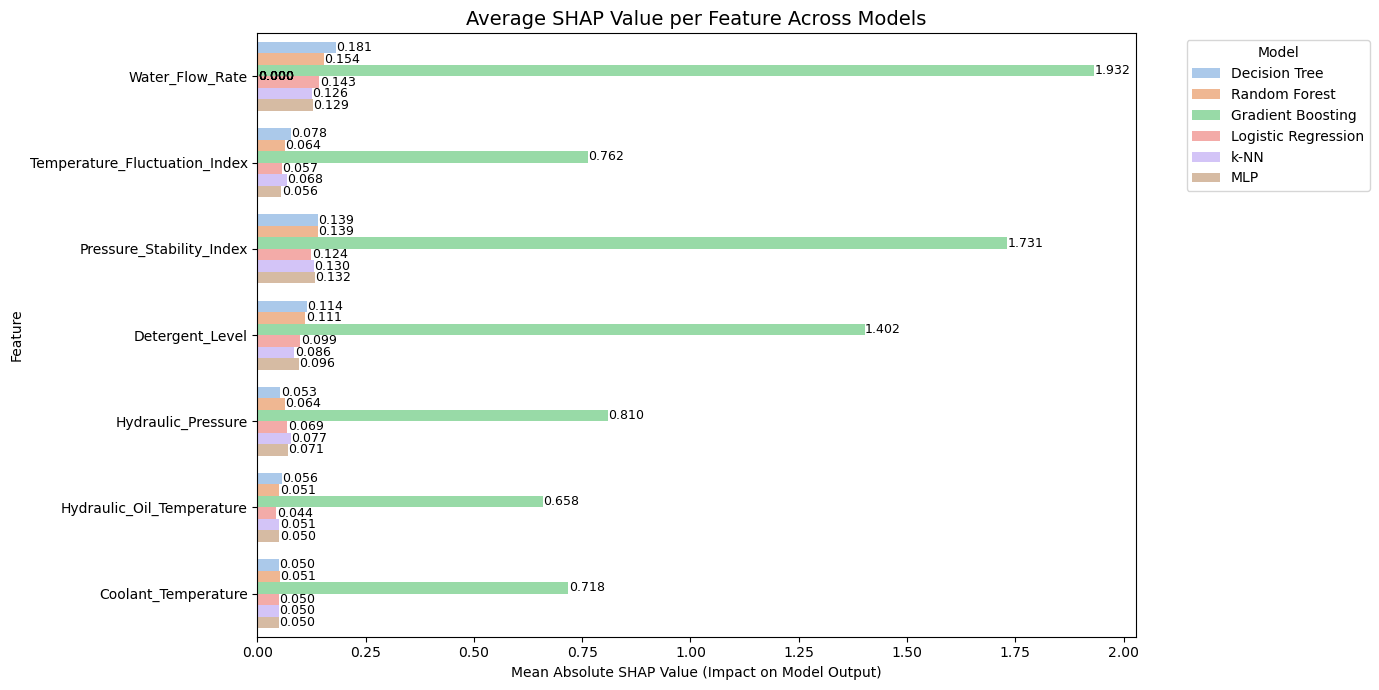

In [48]:
# Reshape the shap_summary_df for plotting
shap_long_df = shap_summary_df.reset_index().melt(
    id_vars='index', var_name='Feature', value_name='Mean_Abs_SHAP'
).rename(columns={'index': 'Model'})

# Use a light pastel palette
light_palette = sns.color_palette("pastel")

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=shap_long_df,
    x='Mean_Abs_SHAP',
    y='Feature',
    hue='Model',
    dodge=True,
    palette=light_palette
)

add_horizontal_labels(ax, ax.patches)

plt.title("Average SHAP Value per Feature Across Models", fontsize=14)
plt.xlabel("Mean Absolute SHAP Value (Impact on Model Output)")
plt.ylabel("Feature")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [44]:
# Rank by overall mean absolute SHAP value across all models
feature_importance_ranked = shap_summary_df.mean(axis=0).sort_values(ascending=False)

print("Overall Feature Importance Ranking (Mean Absolute SHAP):")
display(feature_importance_ranked)

Overall Feature Importance Ranking (Mean Absolute SHAP):


Water_Flow_Rate                  0.444047
Pressure_Stability_Index         0.399204
Detergent_Level                  0.317850
Hydraulic_Pressure               0.190574
Temperature_Fluctuation_Index    0.180726
Coolant_Temperature              0.161423
Hydraulic_Oil_Temperature        0.151592
dtype: float64

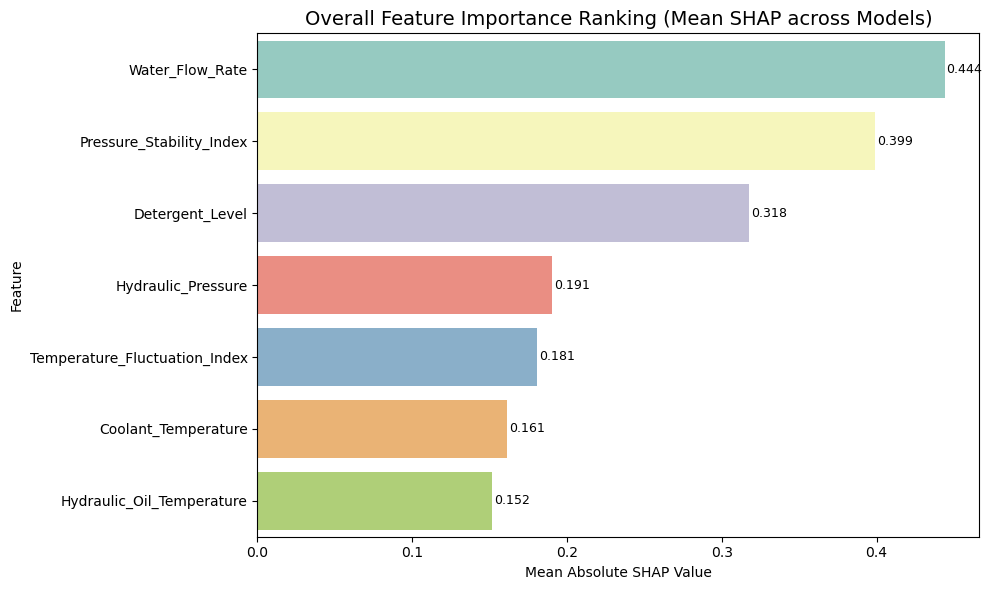

In [46]:
# Custom function to add data labels on horizontal bars
def add_horizontal_labels(ax, rects):
    for rect in rects:
        width = rect.get_width()
        ax.text(
            width + 0.001,  # slight right offset
            rect.get_y() + rect.get_height() / 2.0,
            f"{width:.3f}",
            ha="left",
            va="center",
            fontsize=9,
            color="black"
        )

# Palette
rank_palette = sns.color_palette("Set3")

# Plot with data labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=feature_importance_ranked.values,
    y=feature_importance_ranked.index,
    palette=rank_palette
)

# Add labels
add_horizontal_labels(ax, ax.patches)

# Titles and layout
plt.title("Overall Feature Importance Ranking (Mean SHAP across Models)", fontsize=14)
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [50]:
X_train_balanced_binary.shape 

(146200, 7)

In [51]:
X_train_balanced_binary.columns

Index(['Water_Flow_Rate', 'Temperature_Fluctuation_Index',
       'Pressure_Stability_Index', 'Detergent_Level', 'Hydraulic_Pressure',
       'Hydraulic_Oil_Temperature', 'Coolant_Temperature'],
      dtype='object')

In [52]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def plot_learning_curve(estimator, title, X, y, cv=cv_strategy, return_df=False):
    """
    Plots the learning curve and prints the underlying data.
    Optionally returns it as a DataFrame.
    """
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    cv_mean = np.mean(cv_scores, axis=1)
    cv_std = np.std(cv_scores, axis=1)

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    plt.plot(train_sizes, train_mean, 'o-', color='lightcoral', label="Training Score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='lightcoral')

    plt.plot(train_sizes, cv_mean, 'o-', color='lightgreen', label="CV Score")
    plt.fill_between(train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.1, color='lightgreen')

    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Data Table ---
    df = pd.DataFrame({
        "Training Size": train_sizes,
        "Train Score Mean": train_mean,
        "Train Score Std": train_std,
        "CV Score Mean": cv_mean,
        "CV Score Std": cv_std
    })

    print(f"\nLearning Curve Table for: {title}")
    display(df)

    if return_df:
        return df


Evaluating Decision Tree


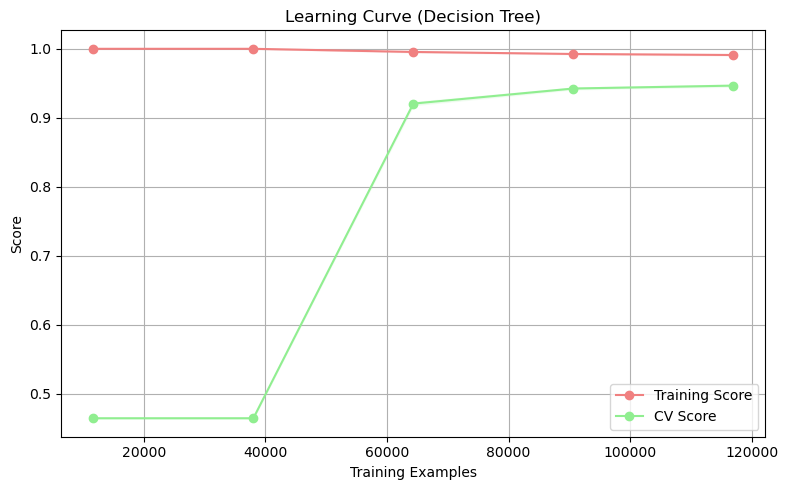


Learning Curve Table for: Learning Curve (Decision Tree)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.995433,0.000683,0.920513,0.002235
3,90644,0.992496,0.000600,0.942415,0.001161
4,116960,0.991021,0.000845,0.946601,0.001429



Evaluating Random Forest


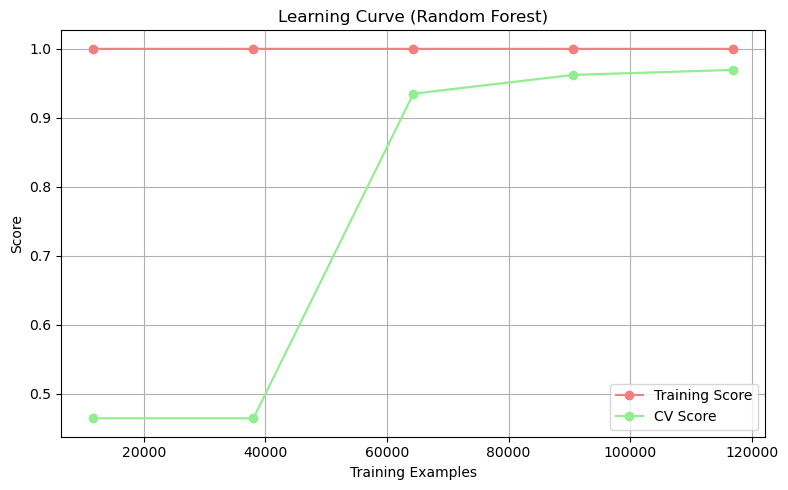


Learning Curve Table for: Learning Curve (Random Forest)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,1.000000,0.000000,0.934945,0.001115
3,90644,0.999998,0.000004,0.962202,0.001211
4,116960,0.999998,0.000003,0.969453,0.000898



Evaluating Gradient Boosting


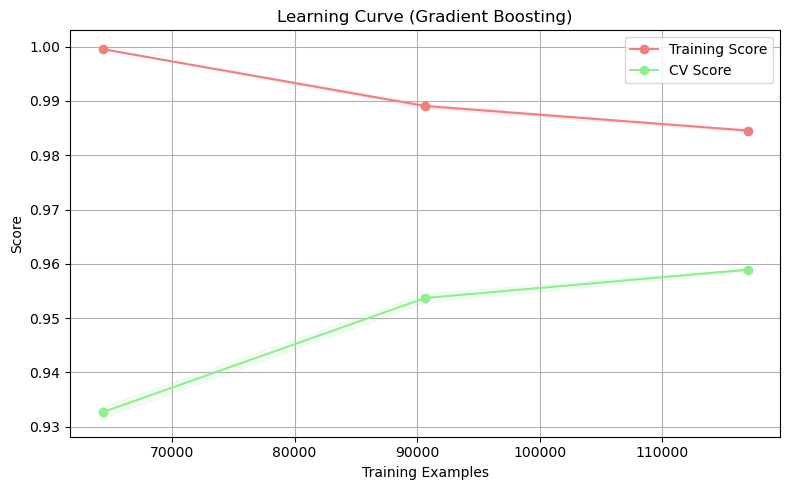


Learning Curve Table for: Learning Curve (Gradient Boosting)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.999559,0.000054,0.932640,0.001109
3,90644,0.989074,0.000379,0.953694,0.000888
4,116960,0.984552,0.000238,0.958899,0.000291



Evaluating Logistic Regression


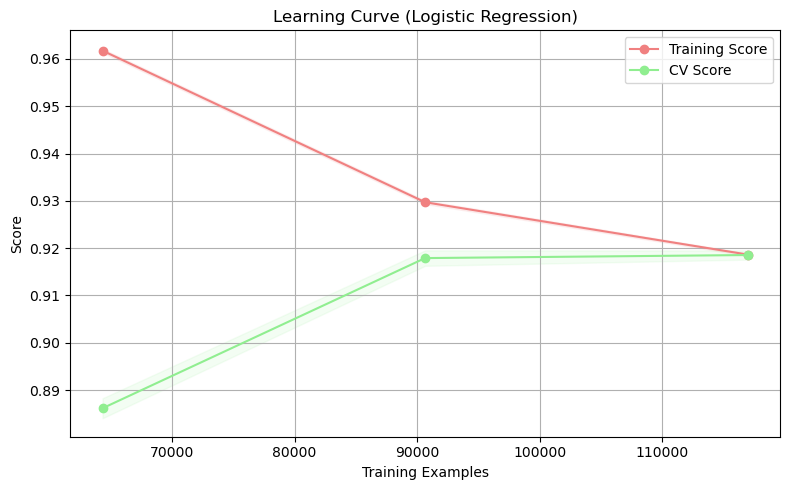


Learning Curve Table for: Learning Curve (Logistic Regression)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.961731,0.000396,0.886163,0.002112
3,90644,0.929701,0.000376,0.917900,0.001632
4,116960,0.918637,0.000263,0.918543,0.000969



Evaluating k-NN


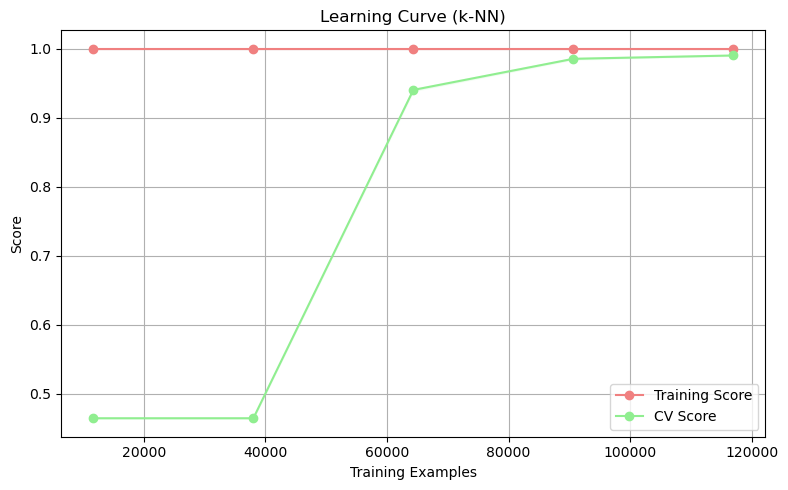


Learning Curve Table for: Learning Curve (k-NN)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.0,0.0,0.464118,0.000014
1,38012,1.0,0.0,0.464118,0.000014
2,64328,1.0,0.0,0.940342,0.001498
3,90644,1.0,0.0,0.985492,0.000998
4,116960,1.0,0.0,0.990321,0.000439



Evaluating MLP


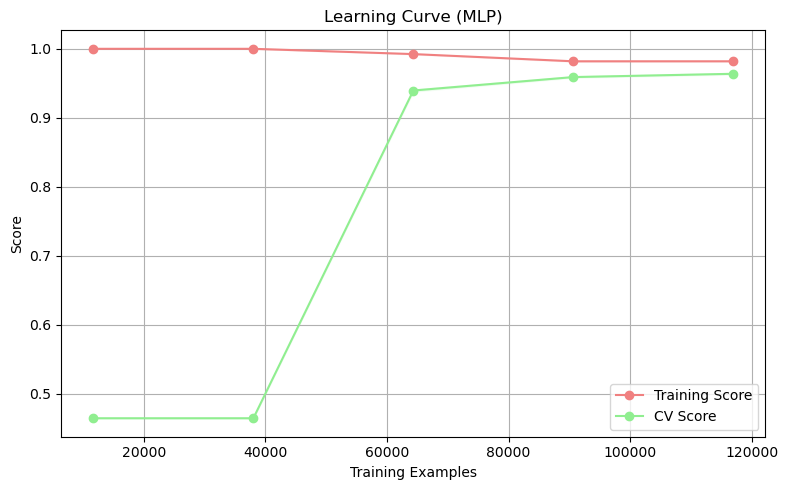


Learning Curve Table for: Learning Curve (MLP)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.992333,0.000423,0.939501,0.001457
3,90644,0.981872,0.000501,0.959001,0.000927
4,116960,0.981876,0.000346,0.963762,0.001045


In [53]:
pipeline_results["X_train_balanced_binary"] = X_train_balanced_binary
pipeline_results["y_train_balanced_binary"] = y_train_balanced_binary

learning_curve_data = {}

for model_name, model in pipeline_results["trained_models"].items():
    print(f"\nEvaluating {model_name}")
    df = plot_learning_curve(
        model,
        title=f"Learning Curve ({model_name})",
        X=pipeline_results["X_train_balanced_binary"],
        y=pipeline_results["y_train_balanced_binary"],
        cv=cv_strategy,
        return_df=True
    )
    learning_curve_data[model_name] = df

In [54]:
import os
import joblib
# Define the export directory
export_path = r"C:\Users\ghaza\Desktop\FYP\Application\AI\models\Training 1 - before shap"

# Create the directory if it doesn't exist
if not os.path.exists(export_path):
    os.makedirs(export_path)

# Iterate over the models and save each one
for model_name, model in pipeline_results["trained_models"].items():
    # Create a file name, replacing spaces with underscores
    file_name = f"{model_name.replace(' ', '_')}.pkl"
    full_path = os.path.join(export_path, file_name)
    joblib.dump(model, full_path)
    print(f"Exported {model_name} to {full_path}")


Exported Decision Tree to C:\Users\ghaza\Desktop\FYP\Application\AI\models\Training 1 - before shap\Decision_Tree.pkl
Exported Random Forest to C:\Users\ghaza\Desktop\FYP\Application\AI\models\Training 1 - before shap\Random_Forest.pkl
Exported Gradient Boosting to C:\Users\ghaza\Desktop\FYP\Application\AI\models\Training 1 - before shap\Gradient_Boosting.pkl
Exported Logistic Regression to C:\Users\ghaza\Desktop\FYP\Application\AI\models\Training 1 - before shap\Logistic_Regression.pkl
Exported k-NN to C:\Users\ghaza\Desktop\FYP\Application\AI\models\Training 1 - before shap\k-NN.pkl
Exported MLP to C:\Users\ghaza\Desktop\FYP\Application\AI\models\Training 1 - before shap\MLP.pkl


In [55]:
X_train_dropped = X_train_balanced_binary.drop(columns=["Hydraulic_Oil_Temperature"])
X_test_dropped = X_test.drop(columns=["Hydraulic_Oil_Temperature"])
assert X_train_dropped.shape[0] == y_train_balanced_binary.shape[0]
assert X_test_dropped.shape[0] == y_test_binary.shape[0]

In [56]:
X_train_dropped.columns

Index(['Water_Flow_Rate', 'Temperature_Fluctuation_Index',
       'Pressure_Stability_Index', 'Detergent_Level', 'Hydraulic_Pressure',
       'Coolant_Temperature'],
      dtype='object')

In [57]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [58]:
def evaluate_pipeline_models_with_regularisation_and_tuning_halving(
    pipeline_results, fine_tune_grids, X_train, y_train, X_test, y_test, cv_folds=5
):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    regularised_models = {
        "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5, ccp_alpha=0.01, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5,
                                                        validation_fraction=0.1, n_iter_no_change=10, random_state=42),
        "Logistic Regression": LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=42),
        "k-NN": KNeighborsClassifier(n_neighbors=3, weights='distance'),
        "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', learning_rate_init=0.001,
                             solver='adam', max_iter=300, early_stopping=True, n_iter_no_change=10, random_state=42)
    }

    all_models = {}
    regularised_results = {}
    fine_tuned_results = {}

    for model_name, base_model in regularised_models.items():
        print(f"\nProcessing {model_name}...")

        reg_model = clone(base_model)
        cv_scores = cross_val_score(reg_model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
        reg_model.fit(X_train, y_train)

        y_pred_test = reg_model.predict(X_test)
        y_pred_train = reg_model.predict(X_train)

        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        fit_status = (
            "Potential Overfitting Detected!" if train_acc > test_acc + 0.1 else
            "Potential Underfitting Detected!" if test_acc > train_acc + 0.1 else
            "Balanced Performance"
        )

        if hasattr(reg_model, "predict_proba"):
            y_probs = reg_model.predict_proba(X_test)[:, 1]
            pr, rc, _ = precision_recall_curve(y_test, y_probs)
            auc_pr = auc(rc, pr)
            auc_roc = roc_auc_score(y_test, y_probs)
        else:
            auc_pr = auc_roc = None

        cm = confusion_matrix(y_test, y_pred_test)
        specificity = cm[0, 0] / cm[0].sum()

        reg_metrics = {
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "F1-Score": f1_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test),
            "Recall": recall_score(y_test, y_pred_test),
            "MCC": matthews_corrcoef(y_test, y_pred_test),
            "AUC-PR": auc_pr,
            "AUC-ROC": auc_roc,
            "Specificity": specificity,
            "CV F1 Mean": cv_scores.mean(),
            "CV F1 Std": cv_scores.std(),
            "Fit Status": fit_status
        }

        regularised_results[model_name] = reg_metrics
        all_models[f"{model_name} - Regularised"] = reg_model

        # Live print regularised model results
        print(f"\nRegularised Results for {model_name}:")
        for k, v in reg_metrics.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

        # === Fine-Tuning with HalvingGridSearchCV ===
        print(f"\nFine-tuning {model_name} using HalvingGridSearchCV...")
        halving_grid = HalvingGridSearchCV(
            estimator=clone(base_model),
            param_grid=fine_tune_grids[model_name],
            scoring="f1",
            cv=cv,
            n_jobs=-1,
            factor=2
        )
        halving_grid.fit(X_train, y_train)
        best_model = halving_grid.best_estimator_
        all_models[f"{model_name} - FineTuned"] = best_model

        y_pred_ft_test = best_model.predict(X_test)
        y_pred_ft_train = best_model.predict(X_train)
        train_acc_ft = accuracy_score(y_train, y_pred_ft_train)
        test_acc_ft = accuracy_score(y_test, y_pred_ft_test)

        fit_status_ft = (
            "Potential Overfitting Detected!" if train_acc_ft > test_acc_ft + 0.1 else
            "Potential Underfitting Detected!" if test_acc_ft > train_acc_ft + 0.1 else
            "Balanced Performance"
        )

        if hasattr(best_model, "predict_proba"):
            auc_roc_ft = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
        else:
            auc_roc_ft = None

        ft_metrics = {
            "Best Params": halving_grid.best_params_,
            "Train Accuracy": train_acc_ft,
            "Test Accuracy": test_acc_ft,
            "F1-Score": f1_score(y_test, y_pred_ft_test),
            "Precision": precision_score(y_test, y_pred_ft_test),
            "Recall": recall_score(y_test, y_pred_ft_test),
            "MCC": matthews_corrcoef(y_test, y_pred_ft_test),
            "AUC-ROC": auc_roc_ft,
            "CV F1 Mean": halving_grid.best_score_,
            "CV F1 Std": halving_grid.cv_results_["std_test_score"][halving_grid.best_index_],
            "Fit Status": fit_status_ft
        }

        fine_tuned_results[model_name] = ft_metrics

        # Live print fine-tuned results
        print(f"\nFine-Tuned Results for {model_name}:")
        for k, v in ft_metrics.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    df_reg = pd.DataFrame(regularised_results).T
    df_ft = pd.DataFrame(fine_tuned_results).T

    print("\nSummary - Regularised Models:\n", df_reg)
    print("\nSummary - Fine-Tuned Models:\n", df_ft)

    return all_models, regularised_results, fine_tuned_results, df_reg, df_ft

In [91]:
fine_tune_grids = {}

for model_name, result_dict in pipeline_results["grid_search_results"].items():
    best_params = result_dict["Best Parameters"]  # corrected key here

    halving_grid = {
        key: [value] for key, value in best_params.items()
    }

    fine_tune_grids[model_name] = halving_grid

In [93]:
all_models, reg_results, ft_results, df_reg, df_ft = evaluate_pipeline_models_with_regularisation_and_tuning_halving(
    pipeline_results=pipeline_results,
    fine_tune_grids=fine_tune_grids,
    X_train=X_train_dropped,
    y_train=y_train_balanced_binary,
    X_test=X_test_dropped,
    y_test=y_test_binary
)


Processing Decision Tree...

Regularised Results for Decision Tree:
Train Accuracy: 0.8726
Test Accuracy: 0.7790
F1-Score: 0.6812
Precision: 0.5655
Recall: 0.8564
MCC: 0.5491
AUC-PR: 0.7044
AUC-ROC: 0.8394
Specificity: 0.7495
CV F1 Mean: 0.8828
CV F1 Std: 0.0017
Fit Status: Balanced Performance

Fine-tuning Decision Tree using HalvingGridSearchCV...

Fine-Tuned Results for Decision Tree:
Best Params: {'max_depth': 20, 'min_samples_split': 2}
Train Accuracy: 0.8726
Test Accuracy: 0.7790
F1-Score: 0.6812
Precision: 0.5655
Recall: 0.8564
MCC: 0.5491
AUC-ROC: 0.8394
CV F1 Mean: 0.8828
CV F1 Std: 0.0017
Fit Status: Balanced Performance

Processing Random Forest...

Regularised Results for Random Forest:
Train Accuracy: 0.9485
Test Accuracy: 0.8717
F1-Score: 0.7904
Precision: 0.7189
Recall: 0.8778
MCC: 0.7065
AUC-PR: 0.8972
AUC-ROC: 0.9468
Specificity: 0.8693
CV F1 Mean: 0.9461
CV F1 Std: 0.0008
Fit Status: Balanced Performance

Fine-tuning Random Forest using HalvingGridSearchCV...

Fine-T

In [94]:
combined_grouped_df = pd.concat([
    df_reg.rename(index=lambda x: f"{x} (Reg)"),
    df_ft.rename(index=lambda x: f"{x} (Tuned)")
])

In [95]:
def plot_grouped_model_comparison(df, metric, title, ylabel, color_reg="lightsteelblue", color_tuned="peachpuff"):
    """
    Plots grouped bars for regularised vs fine-tuned models on a specific metric.
    Handles misaligned model counts gracefully.
    """
    # Extract regularised and tuned models with base names
    reg_df = df[df.index.str.contains(r"\(Reg\)", regex=True)]
    tuned_df = df[df.index.str.contains(r"\(Tuned\)", regex=True)]

    # Align on common model names
    reg_models = [idx.replace(" (Reg)", "") for idx in reg_df.index]
    tuned_models = [idx.replace(" (Tuned)", "") for idx in tuned_df.index]
    common_models = sorted(set(reg_models).intersection(set(tuned_models)))

    if len(common_models) != len(reg_models) or len(common_models) != len(tuned_models):
        print(f"Warning: Some models are missing in one of the groups. Only comparing common models: {common_models}")

    reg_vals = [reg_df.loc[f"{name} (Reg)", metric] for name in common_models]
    tuned_vals = [tuned_df.loc[f"{name} (Tuned)", metric] for name in common_models]

    x = np.arange(len(common_models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width / 2, reg_vals, width, label='Regularised', color=color_reg)
    bars2 = ax.bar(x + width / 2, tuned_vals, width, label='Fine-Tuned', color=color_tuned)

    add_data_labels(ax, bars1)
    add_data_labels(ax, bars2)

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_models, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()

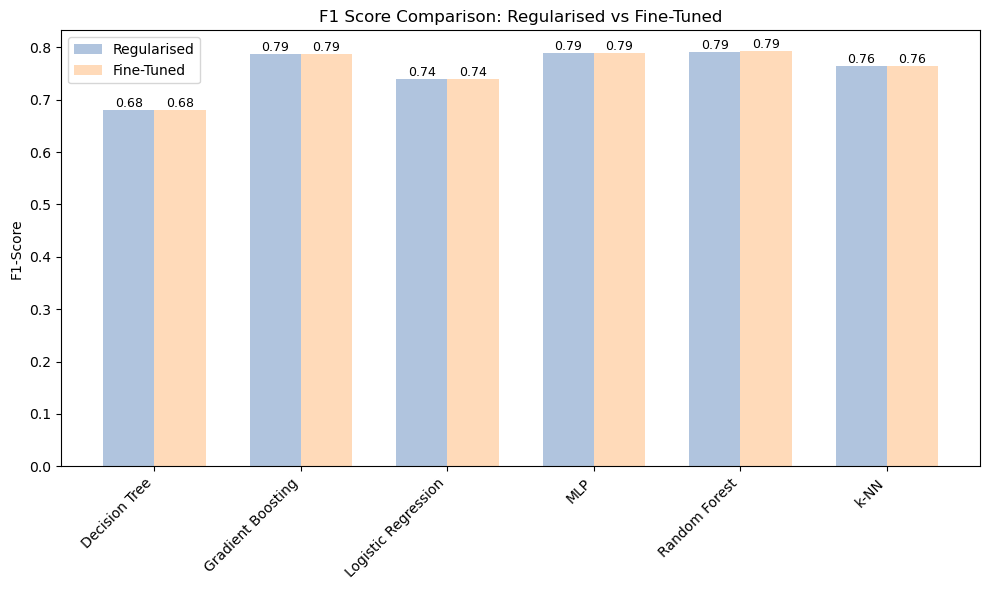

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


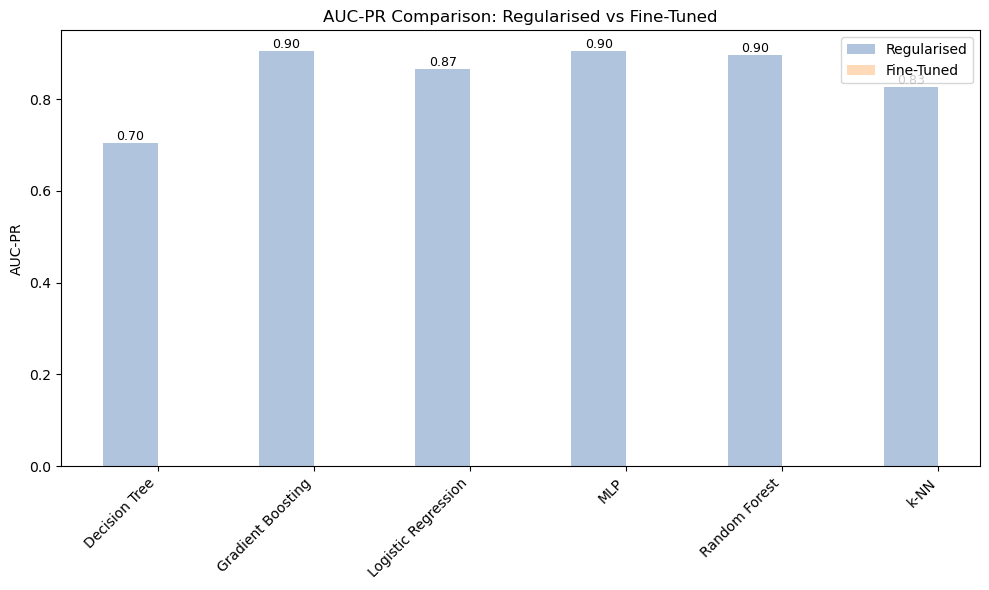

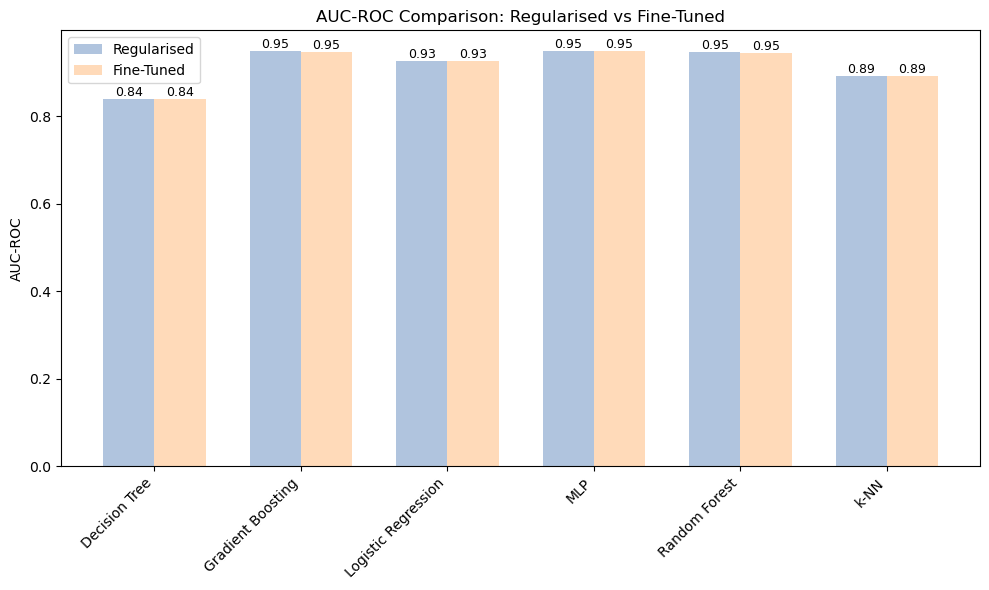

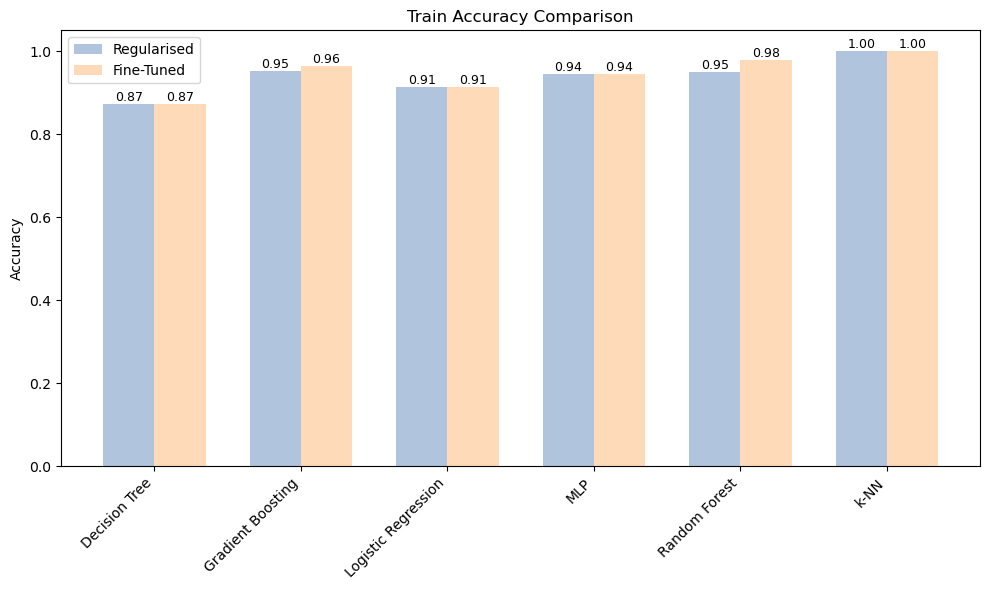

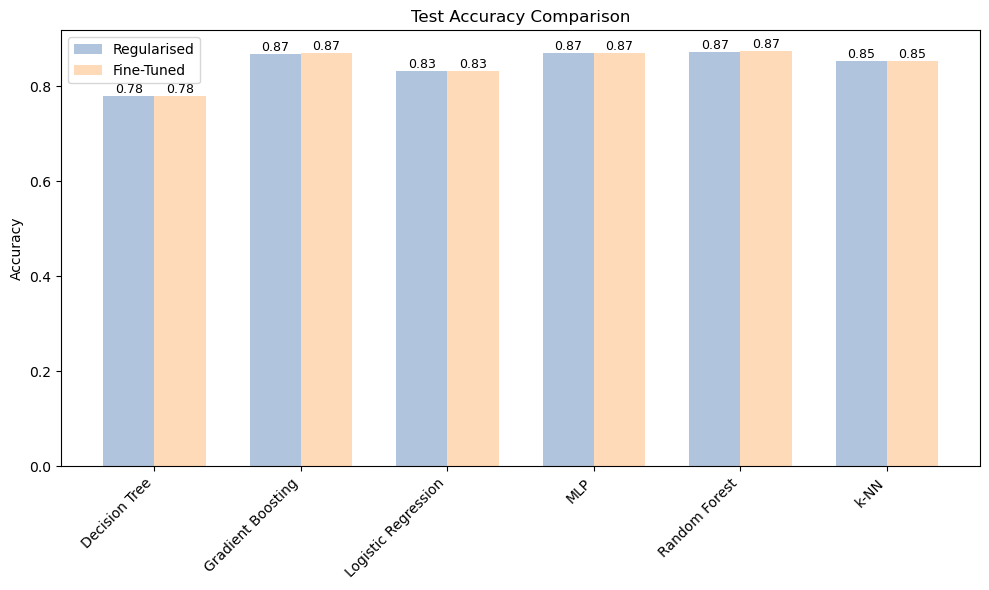

In [96]:
plot_grouped_model_comparison(combined_grouped_df, "F1-Score", "F1 Score Comparison: Regularised vs Fine-Tuned", "F1-Score")
plot_grouped_model_comparison(combined_grouped_df, "AUC-PR", "AUC-PR Comparison: Regularised vs Fine-Tuned", "AUC-PR")
plot_grouped_model_comparison(combined_grouped_df, "AUC-ROC", "AUC-ROC Comparison: Regularised vs Fine-Tuned", "AUC-ROC")
plot_grouped_model_comparison(combined_grouped_df, "Train Accuracy", "Train Accuracy Comparison", "Accuracy")
plot_grouped_model_comparison(combined_grouped_df, "Test Accuracy", "Test Accuracy Comparison", "Accuracy")

🔼 If CV F1 ≈ Test F1 → model generalises well (balanced)

🔽 If CV F1 ≫ Test F1 → overfitting risk

🔼 If CV F1 ≪ Test F1 → test set might be easier / model underfits training


In [98]:
def plot_cv_vs_test_f1(results_df, title="CV vs Test F1 Scores"):
    plt.figure(figsize=(10, 6))
    
    # Convert index to x-axis positions
    x = np.arange(len(results_df))
    
    # Explicitly convert all required columns to numeric with coercion
    test_f1 = pd.to_numeric(results_df["F1-Score"], errors='coerce').fillna(0).astype(float).values
    cv_f1 = pd.to_numeric(results_df["CV F1 Mean"], errors='coerce').fillna(0).astype(float).values
    cv_std = pd.to_numeric(results_df["CV F1 Std"], errors='coerce').fillna(0).astype(float).values

    # Ensure all arrays have the same length
    min_len = min(len(test_f1), len(cv_f1), len(cv_std), len(x))
    test_f1, cv_f1, cv_std, x = test_f1[:min_len], cv_f1[:min_len], cv_std[:min_len], x[:min_len]

    plt.plot(x, test_f1, marker='o', label='Test F1', color='salmon')
    plt.plot(x, cv_f1, marker='s', label='CV F1', color='seagreen')
    plt.fill_between(x, cv_f1 - cv_std, cv_f1 + cv_std, 
                     color='lightblue', alpha=0.4, label='CV Std')

    plt.title(title)
    plt.ylabel("F1 Score")
    plt.xticks(x, results_df.index[:min_len], rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

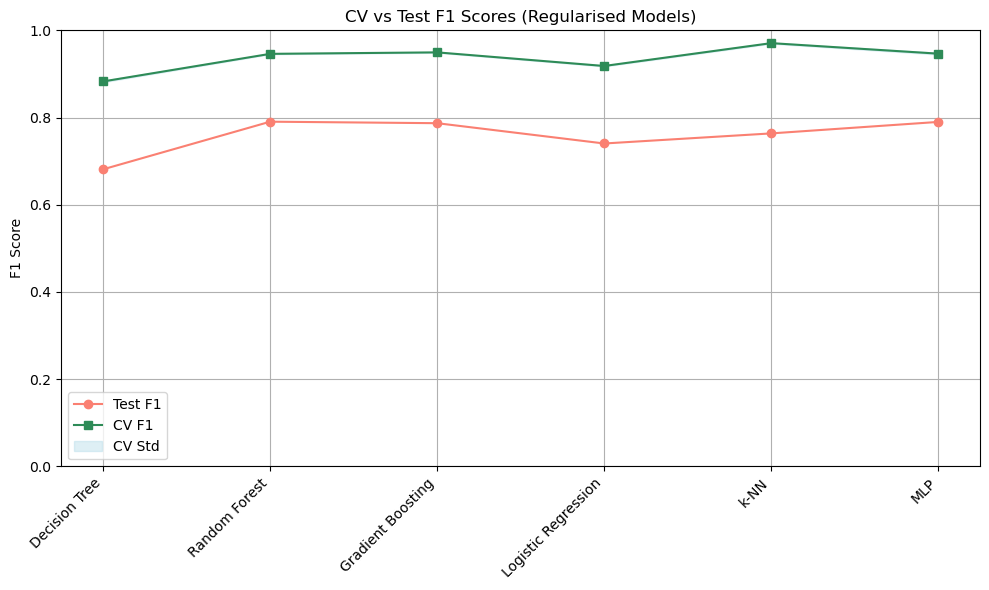

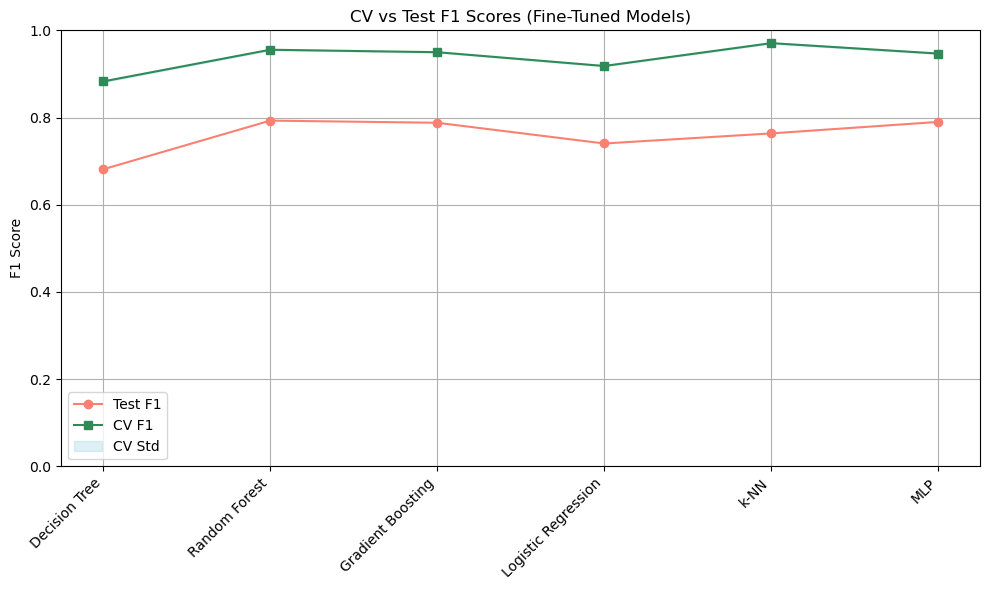

In [99]:
plot_cv_vs_test_f1(df_reg, title="CV vs Test F1 Scores (Regularised Models)")
plot_cv_vs_test_f1(df_ft, title="CV vs Test F1 Scores (Fine-Tuned Models)")

For predictive maintenance, the best metric depends on what failure means for you:

-- Metric	Why It's Important
- F1-Score	Good balance if both precision and recall are important.
- Recall	 Most important if missing a failure is costly.
- AUC-PR	Best if your data is imbalanced (rare failures).
- AUC-ROC	For general discriminatory power.


Evaluating Learning Curve for Regularised Model: Decision Tree


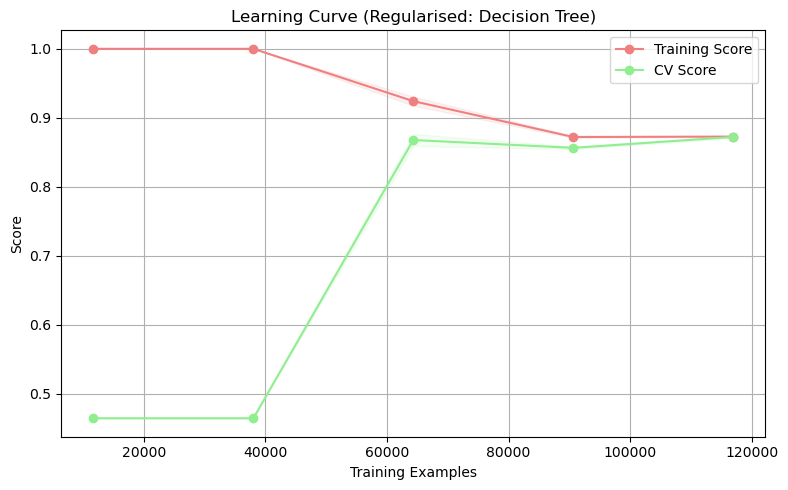


Learning Curve Table for: Learning Curve (Regularised: Decision Tree)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.924052,0.006650,0.867715,0.008766
3,90644,0.872075,0.001217,0.856313,0.002097
4,116960,0.872664,0.000537,0.872107,0.001583


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.924052,0.006650,0.867715,0.008766
3,90644,0.872075,0.001217,0.856313,0.002097
4,116960,0.872664,0.000537,0.872107,0.001583



Evaluating Learning Curve for Regularised Model: Random Forest


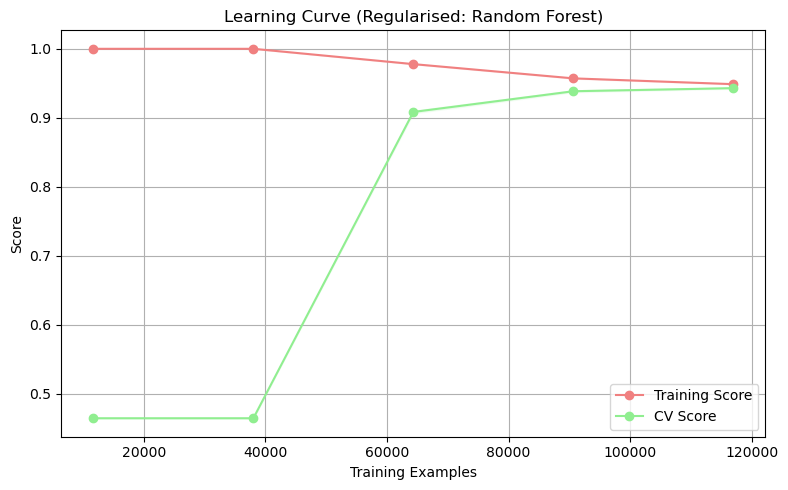


Learning Curve Table for: Learning Curve (Regularised: Random Forest)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.977792,0.000331,0.908399,0.001817
3,90644,0.957125,0.000434,0.938440,0.001300
4,116960,0.948712,0.000262,0.942941,0.000826


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.977792,0.000331,0.908399,0.001817
3,90644,0.957125,0.000434,0.938440,0.001300
4,116960,0.948712,0.000262,0.942941,0.000826



Evaluating Learning Curve for Regularised Model: Gradient Boosting


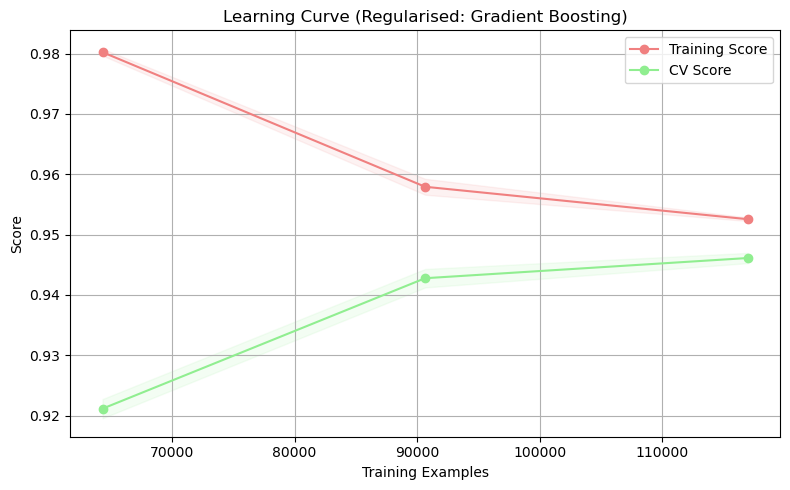


Learning Curve Table for: Learning Curve (Regularised: Gradient Boosting)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.980220,0.000562,0.921156,0.001590
3,90644,0.957921,0.001319,0.942770,0.001532
4,116960,0.952548,0.000292,0.946115,0.000846


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.980220,0.000562,0.921156,0.001590
3,90644,0.957921,0.001319,0.942770,0.001532
4,116960,0.952548,0.000292,0.946115,0.000846



Evaluating Learning Curve for Regularised Model: Logistic Regression


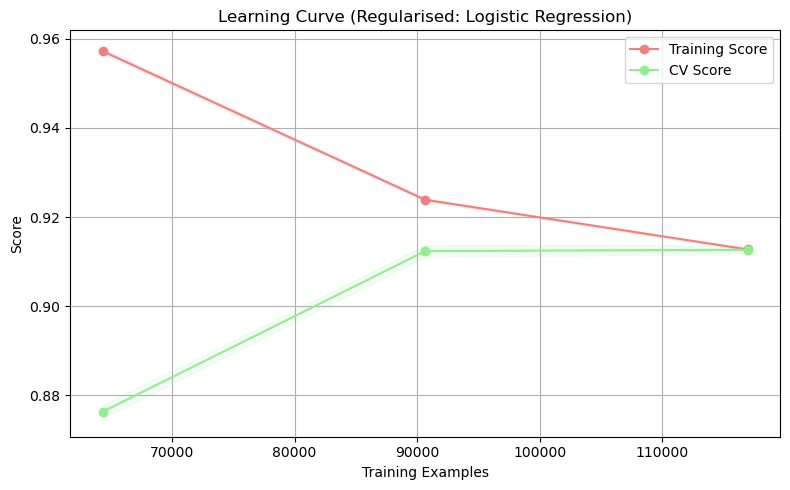


Learning Curve Table for: Learning Curve (Regularised: Logistic Regression)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.957238,0.000520,0.876279,0.001451
3,90644,0.923878,0.000325,0.912339,0.001317
4,116960,0.912719,0.000276,0.912654,0.000948


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.957238,0.000520,0.876279,0.001451
3,90644,0.923878,0.000325,0.912339,0.001317
4,116960,0.912719,0.000276,0.912654,0.000948



Evaluating Learning Curve for Regularised Model: k-NN


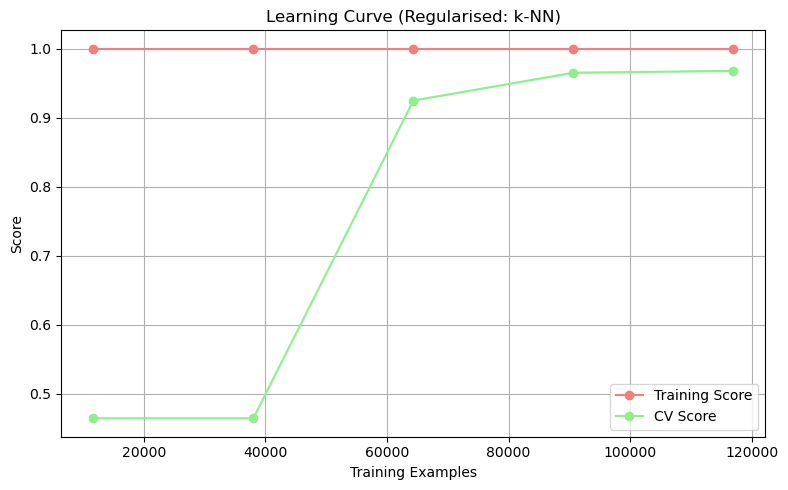


Learning Curve Table for: Learning Curve (Regularised: k-NN)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.0,0.0,0.464118,0.000014
1,38012,1.0,0.0,0.464118,0.000014
2,64328,1.0,0.0,0.924959,0.001057
3,90644,1.0,0.0,0.965267,0.001683
4,116960,1.0,0.0,0.967969,0.001378


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.0,0.0,0.464118,0.000014
1,38012,1.0,0.0,0.464118,0.000014
2,64328,1.0,0.0,0.924959,0.001057
3,90644,1.0,0.0,0.965267,0.001683
4,116960,1.0,0.0,0.967969,0.001378



Evaluating Learning Curve for Regularised Model: MLP


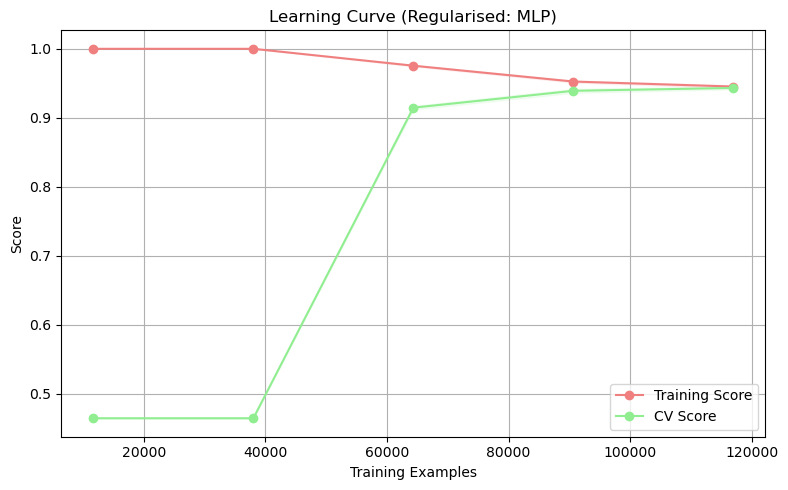


Learning Curve Table for: Learning Curve (Regularised: MLP)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.975488,0.001066,0.914610,0.002614
3,90644,0.952511,0.001452,0.939063,0.002983
4,116960,0.945250,0.001794,0.943228,0.002017


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.975488,0.001066,0.914610,0.002614
3,90644,0.952511,0.001452,0.939063,0.002983
4,116960,0.945250,0.001794,0.943228,0.002017


In [100]:
learning_curve_data_reg = {}

# Make sure you're passing the correct train set
for model_name, model in all_models.items():
    if "Regularised" in model_name:
        base_name = model_name.replace(" - Regularised", "")
        print(f"\nEvaluating Learning Curve for Regularised Model: {base_name}")
        
        df = plot_learning_curve(
            model,
            title=f"Learning Curve (Regularised: {base_name})",
            X=X_train_dropped,
            y=y_train_balanced_binary,
            return_df=True
        )
        
        learning_curve_data_reg[base_name] = df
        display(df)


Evaluating Learning Curve for Fine-Tuned Model: Decision Tree


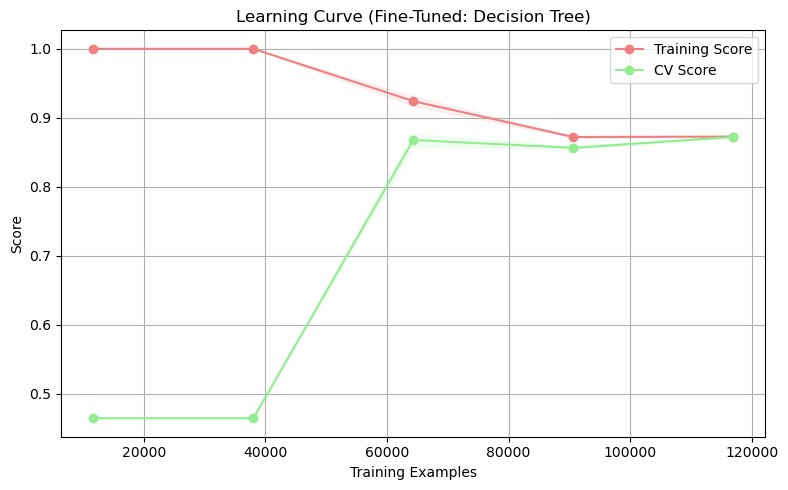


Learning Curve Table for: Learning Curve (Fine-Tuned: Decision Tree)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.924052,0.006650,0.867715,0.008766
3,90644,0.872075,0.001217,0.856313,0.002097
4,116960,0.872664,0.000537,0.872107,0.001583


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.924052,0.006650,0.867715,0.008766
3,90644,0.872075,0.001217,0.856313,0.002097
4,116960,0.872664,0.000537,0.872107,0.001583



Evaluating Learning Curve for Fine-Tuned Model: Random Forest


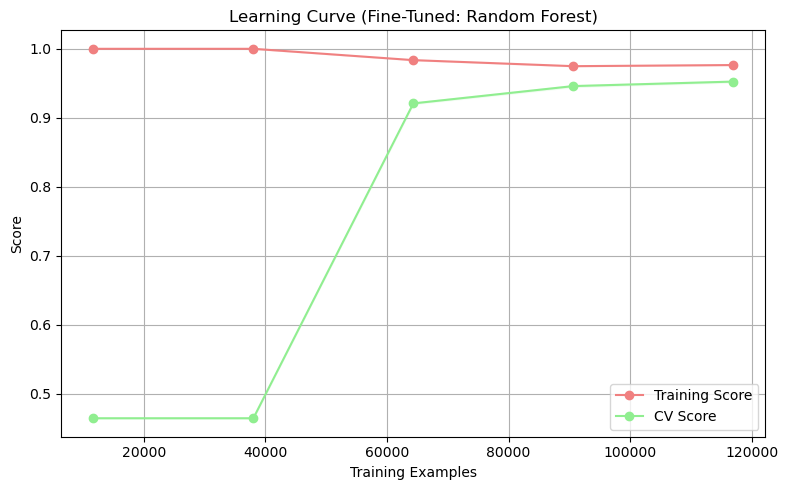


Learning Curve Table for: Learning Curve (Fine-Tuned: Random Forest)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.983569,0.000253,0.920814,0.000986
3,90644,0.974809,0.000276,0.945917,0.001361
4,116960,0.976442,0.000073,0.952449,0.001141


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.983569,0.000253,0.920814,0.000986
3,90644,0.974809,0.000276,0.945917,0.001361
4,116960,0.976442,0.000073,0.952449,0.001141



Evaluating Learning Curve for Fine-Tuned Model: Gradient Boosting


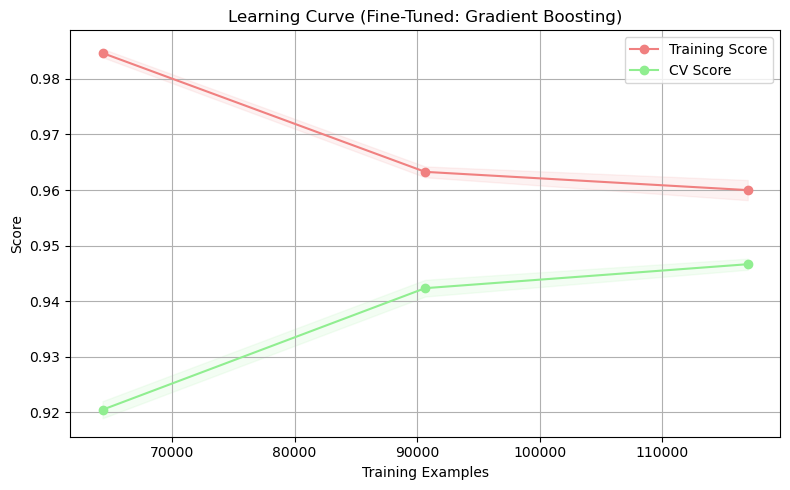


Learning Curve Table for: Learning Curve (Fine-Tuned: Gradient Boosting)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.984651,0.000758,0.920499,0.001534
3,90644,0.963278,0.000973,0.942360,0.001503
4,116960,0.959997,0.001809,0.946669,0.000998


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.984651,0.000758,0.920499,0.001534
3,90644,0.963278,0.000973,0.942360,0.001503
4,116960,0.959997,0.001809,0.946669,0.000998



Evaluating Learning Curve for Fine-Tuned Model: Logistic Regression


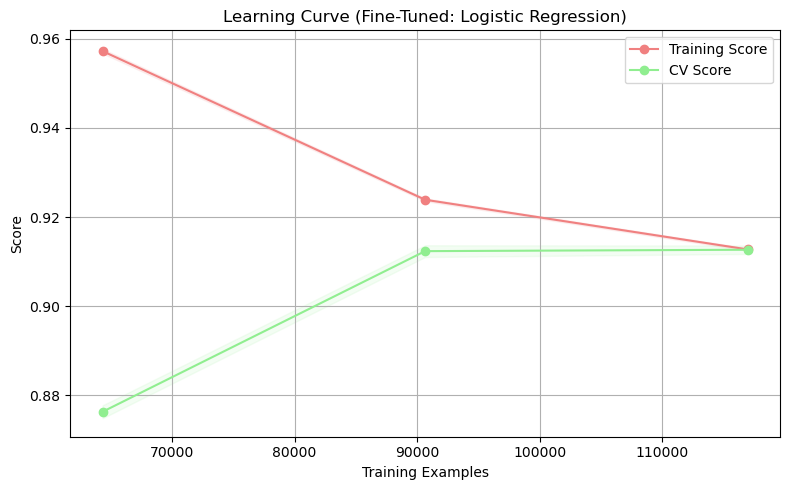


Learning Curve Table for: Learning Curve (Fine-Tuned: Logistic Regression)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.957238,0.000520,0.876279,0.001451
3,90644,0.923878,0.000325,0.912339,0.001317
4,116960,0.912719,0.000276,0.912654,0.000948


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.957238,0.000520,0.876279,0.001451
3,90644,0.923878,0.000325,0.912339,0.001317
4,116960,0.912719,0.000276,0.912654,0.000948



Evaluating Learning Curve for Fine-Tuned Model: k-NN


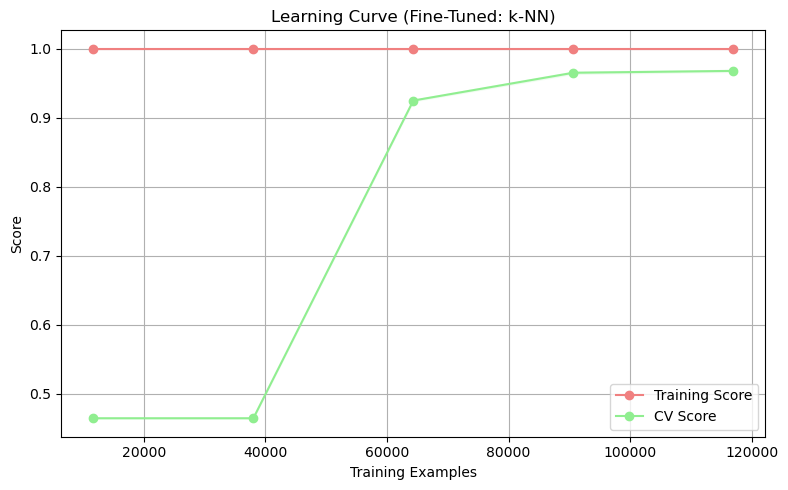


Learning Curve Table for: Learning Curve (Fine-Tuned: k-NN)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.0,0.0,0.464118,0.000014
1,38012,1.0,0.0,0.464118,0.000014
2,64328,1.0,0.0,0.924959,0.001057
3,90644,1.0,0.0,0.965267,0.001683
4,116960,1.0,0.0,0.967969,0.001378


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.0,0.0,0.464118,0.000014
1,38012,1.0,0.0,0.464118,0.000014
2,64328,1.0,0.0,0.924959,0.001057
3,90644,1.0,0.0,0.965267,0.001683
4,116960,1.0,0.0,0.967969,0.001378



Evaluating Learning Curve for Fine-Tuned Model: MLP


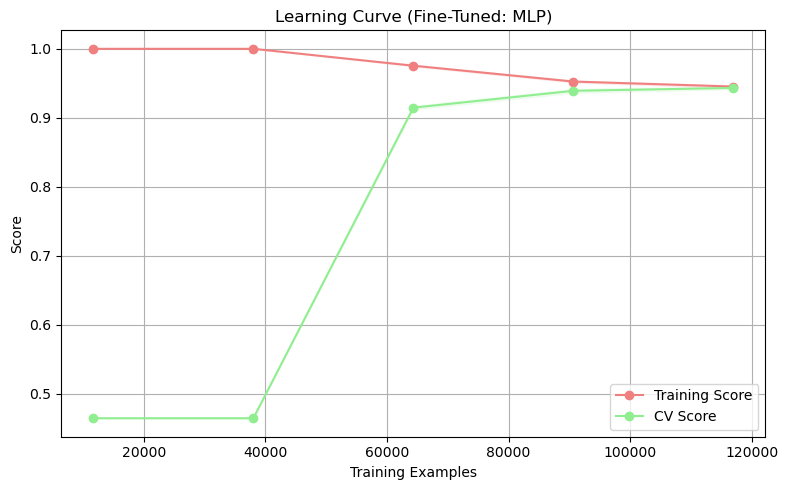


Learning Curve Table for: Learning Curve (Fine-Tuned: MLP)


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.975488,0.001066,0.914610,0.002614
3,90644,0.952511,0.001452,0.939063,0.002983
4,116960,0.945250,0.001794,0.943228,0.002017


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.975488,0.001066,0.914610,0.002614
3,90644,0.952511,0.001452,0.939063,0.002983
4,116960,0.945250,0.001794,0.943228,0.002017


In [101]:
learning_curve_data_ft = {}

for model_name, model in all_models.items():
    if "FineTuned" in model_name:
        base_name = model_name.replace(" - FineTuned", "")
        print(f"\nEvaluating Learning Curve for Fine-Tuned Model: {base_name}")

        df = plot_learning_curve(
            model,
            title=f"Learning Curve (Fine-Tuned: {base_name})",
            X=X_train_dropped,
            y=y_train_balanced_binary,
            return_df=True
        )

        learning_curve_data_ft[base_name] = df
        display(df)

In [102]:
from IPython.display import display

def plot_combined_learning_curves_from_data(learning_curve_data_dict, title_prefix="Learning Curve"):
    """
    Plots combined learning curves and displays the underlying DataFrame for each model.
    """
    for model_name, df in learning_curve_data_dict.items():
        if not isinstance(df, pd.DataFrame):
            continue

        x = df["Training Size"].values
        train_mean = df["Train Score Mean"].values
        train_std = df["Train Score Std"].values
        cv_mean = df["CV Score Mean"].values
        cv_std = df["CV Score Std"].values

        # Plot for individual model
        plt.figure(figsize=(10, 5))
        plt.plot(x, train_mean, 'o-', label="Training Score", color='lightcoral')
        plt.fill_between(x, train_mean - train_std, train_mean + train_std, alpha=0.1, color='lightcoral')

        plt.plot(x, cv_mean, 's--', label="CV Score", color='lightgreen')
        plt.fill_between(x, cv_mean - cv_std, cv_mean + cv_std, alpha=0.1, color='lightgreen')

        plt.title(f"{title_prefix} - {model_name}")
        plt.xlabel("Training Examples")
        plt.ylabel("F1 Score")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Display associated table
        print(f"Learning Curve Data for: {model_name}")
        display(df)

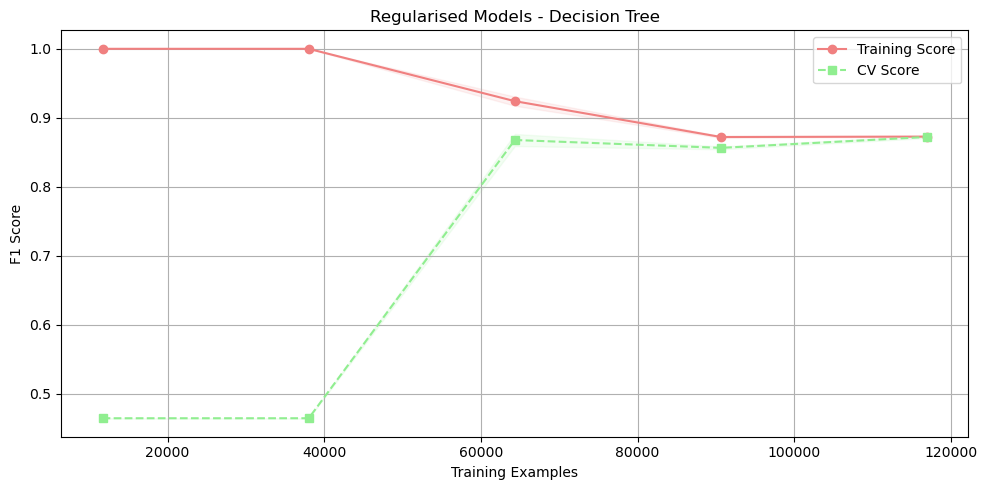

Learning Curve Data for: Decision Tree


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.924052,0.006650,0.867715,0.008766
3,90644,0.872075,0.001217,0.856313,0.002097
4,116960,0.872664,0.000537,0.872107,0.001583


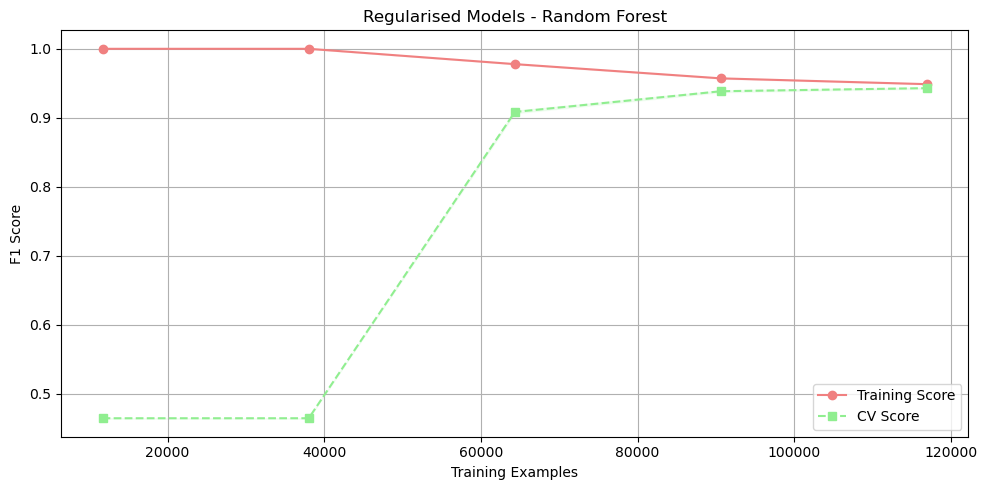

Learning Curve Data for: Random Forest


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.977792,0.000331,0.908399,0.001817
3,90644,0.957125,0.000434,0.938440,0.001300
4,116960,0.948712,0.000262,0.942941,0.000826


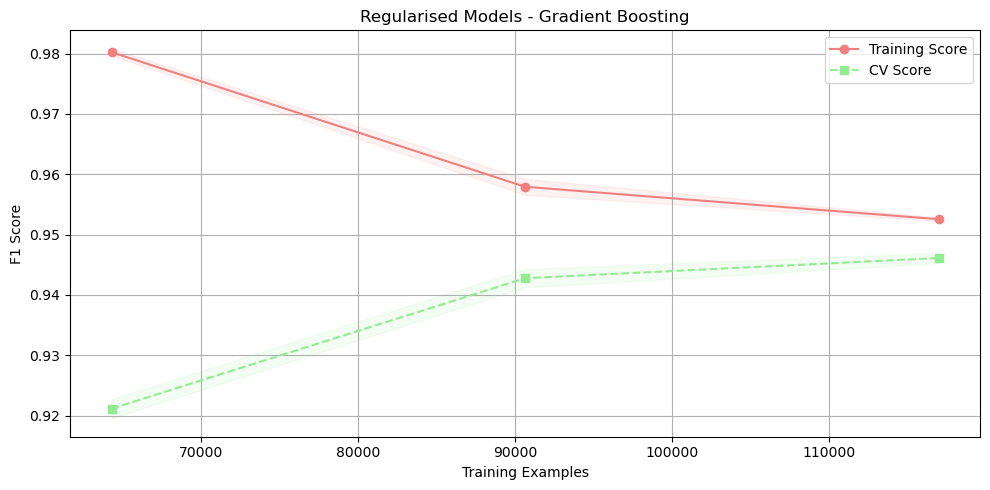

Learning Curve Data for: Gradient Boosting


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.980220,0.000562,0.921156,0.001590
3,90644,0.957921,0.001319,0.942770,0.001532
4,116960,0.952548,0.000292,0.946115,0.000846


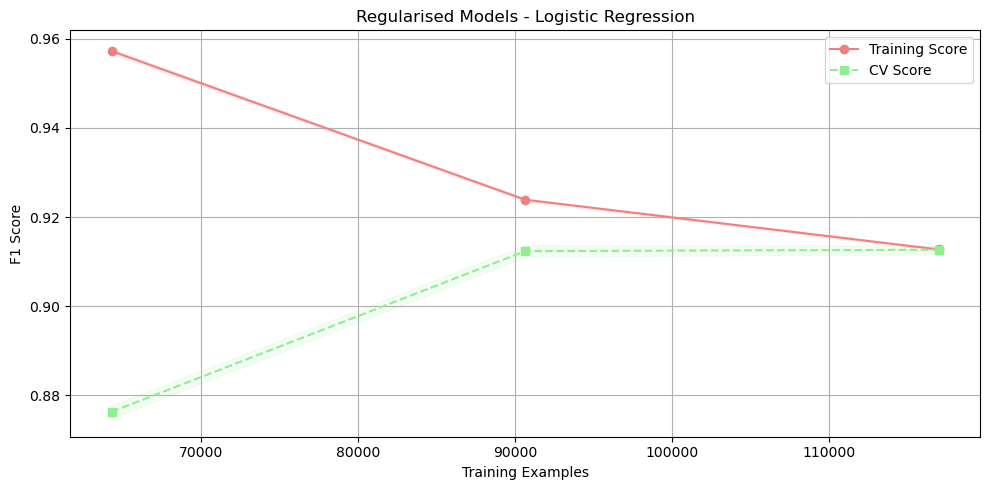

Learning Curve Data for: Logistic Regression


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.957238,0.000520,0.876279,0.001451
3,90644,0.923878,0.000325,0.912339,0.001317
4,116960,0.912719,0.000276,0.912654,0.000948


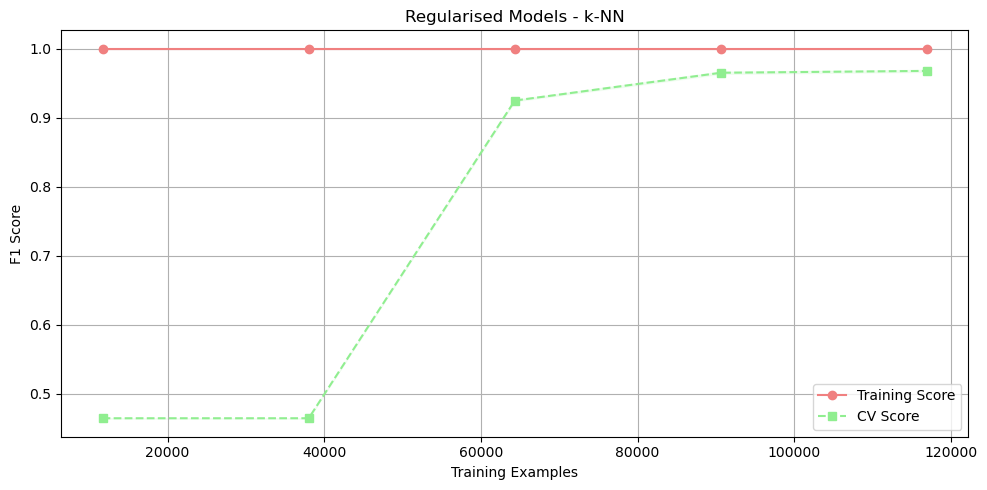

Learning Curve Data for: k-NN


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.0,0.0,0.464118,0.000014
1,38012,1.0,0.0,0.464118,0.000014
2,64328,1.0,0.0,0.924959,0.001057
3,90644,1.0,0.0,0.965267,0.001683
4,116960,1.0,0.0,0.967969,0.001378


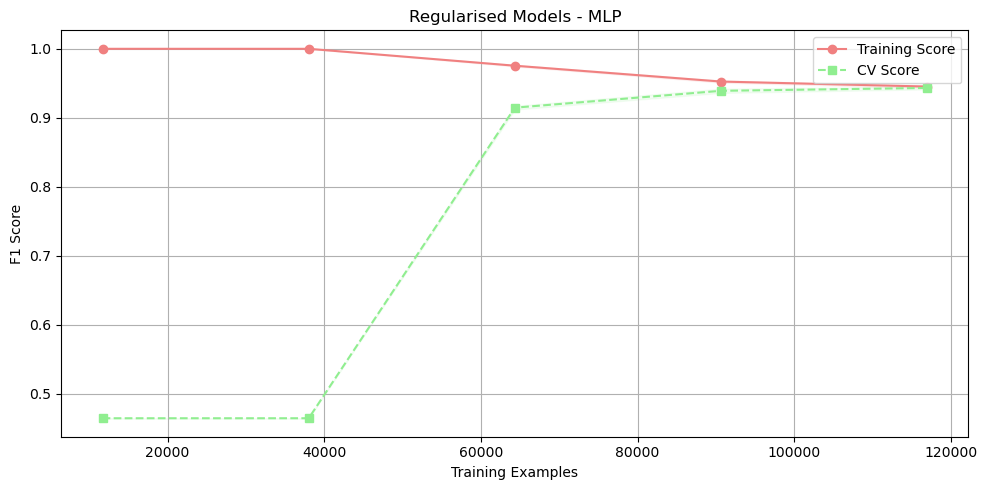

Learning Curve Data for: MLP


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.975488,0.001066,0.914610,0.002614
3,90644,0.952511,0.001452,0.939063,0.002983
4,116960,0.945250,0.001794,0.943228,0.002017


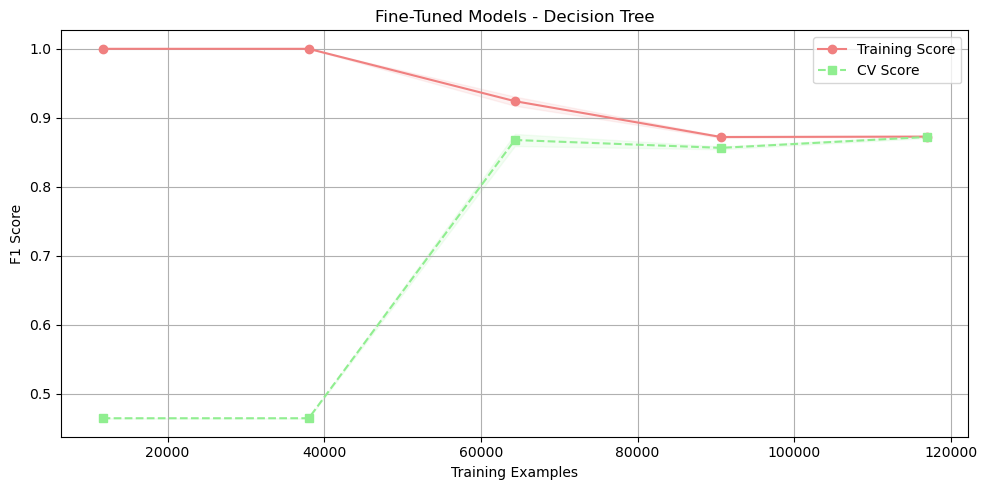

Learning Curve Data for: Decision Tree


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.924052,0.006650,0.867715,0.008766
3,90644,0.872075,0.001217,0.856313,0.002097
4,116960,0.872664,0.000537,0.872107,0.001583


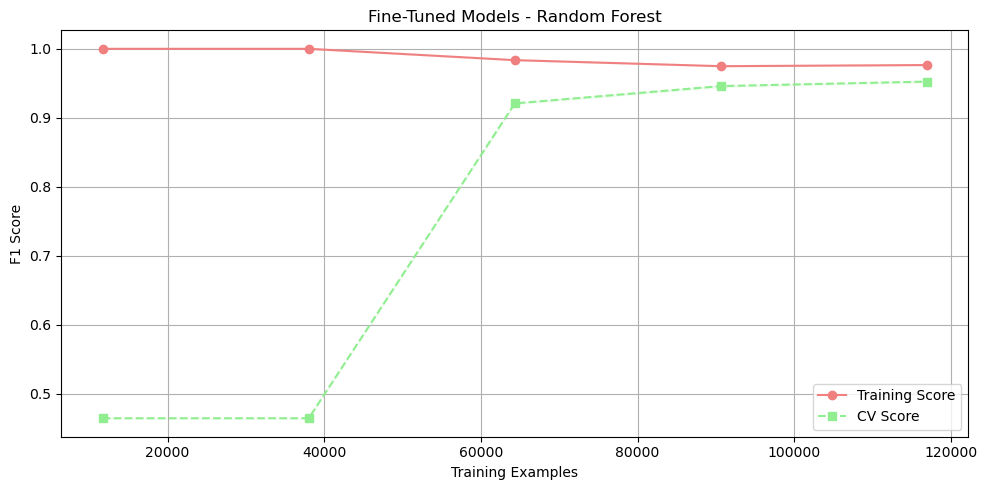

Learning Curve Data for: Random Forest


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.983569,0.000253,0.920814,0.000986
3,90644,0.974809,0.000276,0.945917,0.001361
4,116960,0.976442,0.000073,0.952449,0.001141


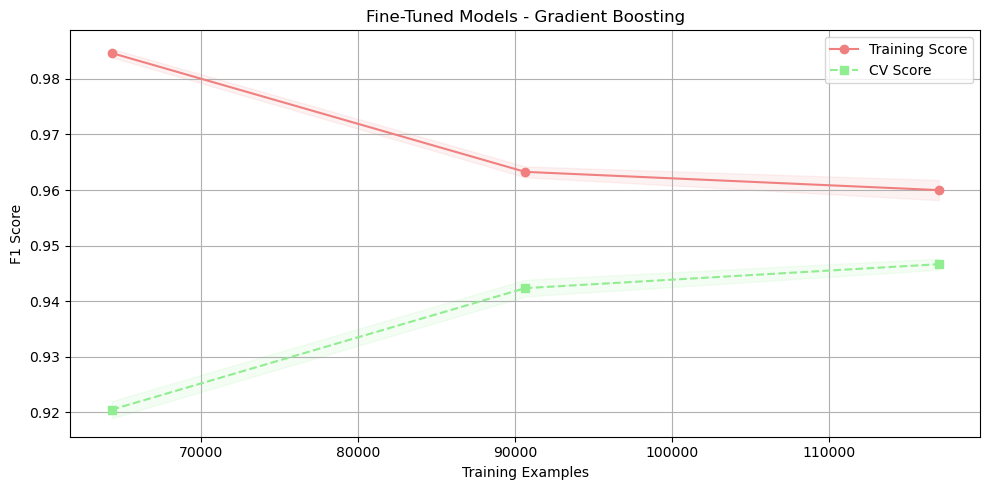

Learning Curve Data for: Gradient Boosting


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.984651,0.000758,0.920499,0.001534
3,90644,0.963278,0.000973,0.942360,0.001503
4,116960,0.959997,0.001809,0.946669,0.000998


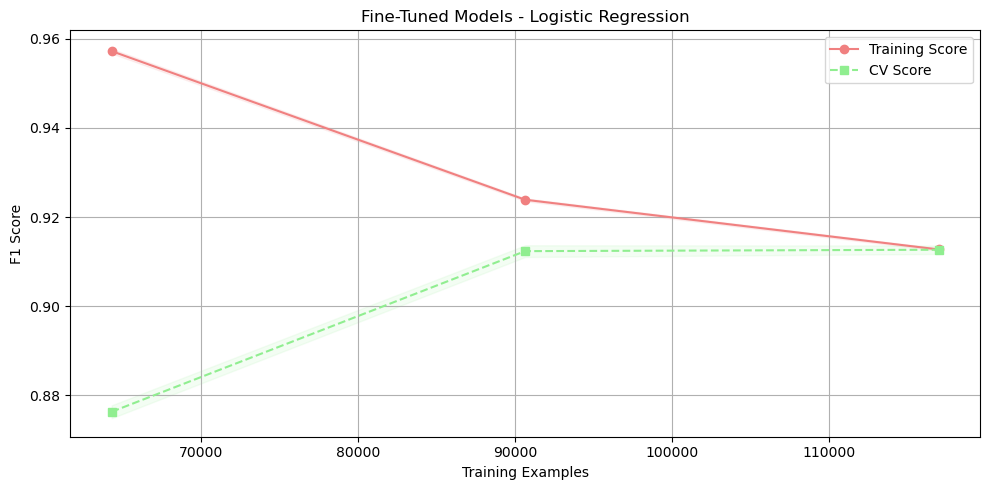

Learning Curve Data for: Logistic Regression


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,NaN,NaN,NaN,NaN
1,38012,NaN,NaN,NaN,NaN
2,64328,0.957238,0.000520,0.876279,0.001451
3,90644,0.923878,0.000325,0.912339,0.001317
4,116960,0.912719,0.000276,0.912654,0.000948


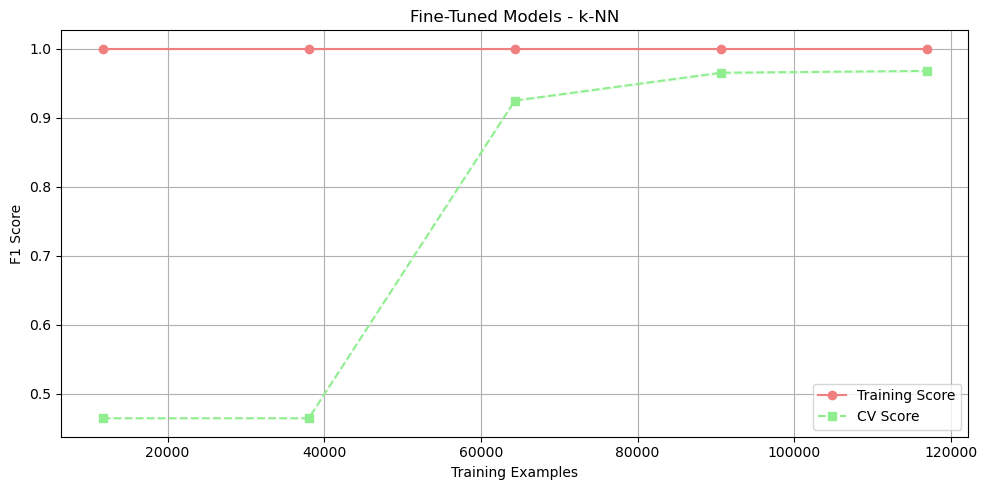

Learning Curve Data for: k-NN


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.0,0.0,0.464118,0.000014
1,38012,1.0,0.0,0.464118,0.000014
2,64328,1.0,0.0,0.924959,0.001057
3,90644,1.0,0.0,0.965267,0.001683
4,116960,1.0,0.0,0.967969,0.001378


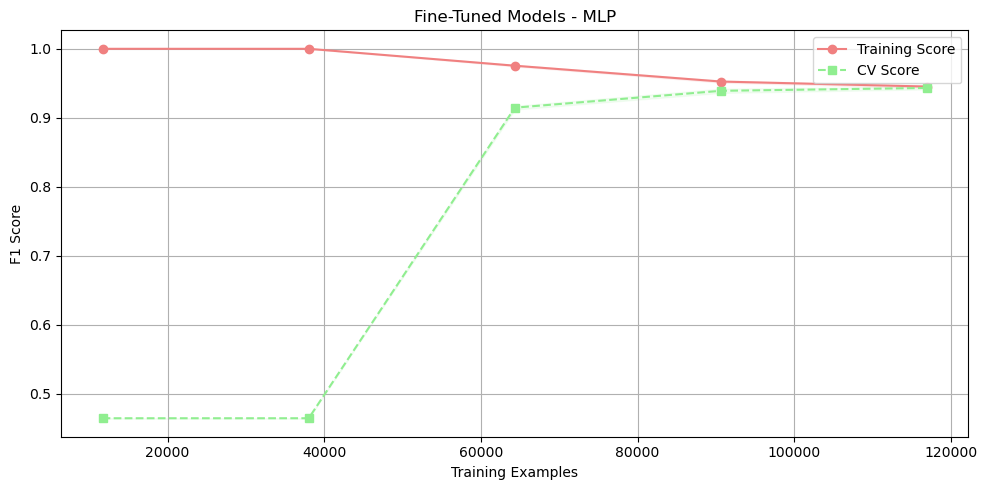

Learning Curve Data for: MLP


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,1.000000,0.000000,0.464118,0.000014
1,38012,1.000000,0.000000,0.464118,0.000014
2,64328,0.975488,0.001066,0.914610,0.002614
3,90644,0.952511,0.001452,0.939063,0.002983
4,116960,0.945250,0.001794,0.943228,0.002017


In [103]:
# Plot and show data for regularised models
plot_combined_learning_curves_from_data(learning_curve_data_reg, title_prefix="Regularised Models")

# Plot and show data for fine-tuned models
plot_combined_learning_curves_from_data(learning_curve_data_ft, title_prefix="Fine-Tuned Models")

In [106]:
# Define model export path
model_export_path = "C:/Users/ghaza/Desktop/FYP/Application/AI/models/Finetuned_Reg_Binary"
os.makedirs(model_export_path, exist_ok=True)

# Save all models with `.pkl` extension
for model_name, model in all_models.items():
    # Sanitize model name to avoid filesystem issues
    safe_model_name = model_name.replace(" ", "_").replace("-", "_")
    file_name = f"{safe_model_name}.pkl"
    full_path = os.path.join(model_export_path, file_name)
    joblib.dump(model, full_path, protocol = 4)
    print(f"Saved: {file_name}")

Saved: Decision_Tree___Regularised.pkl
Saved: Decision_Tree___FineTuned.pkl
Saved: Random_Forest___Regularised.pkl
Saved: Random_Forest___FineTuned.pkl
Saved: Gradient_Boosting___Regularised.pkl
Saved: Gradient_Boosting___FineTuned.pkl
Saved: Logistic_Regression___Regularised.pkl
Saved: Logistic_Regression___FineTuned.pkl
Saved: k_NN___Regularised.pkl
Saved: k_NN___FineTuned.pkl
Saved: MLP___Regularised.pkl
Saved: MLP___FineTuned.pkl


In [107]:
# Define export path for dropped datasets
data_export_path = "C:/Users/ghaza/Desktop/FYP/Application/AI/data/dropped_final_training"
os.makedirs(data_export_path, exist_ok=True)

# Save dropped datasets
X_train_dropped.to_csv(os.path.join(data_export_path, "X_train_dropped.csv"), index=False)
X_test_dropped.to_csv(os.path.join(data_export_path, "X_test_dropped.csv"), index=False)
y_train_balanced_binary.to_csv(os.path.join(data_export_path, "y_train_balanced_binary.csv"), index=False)
y_test_binary.to_csv(os.path.join(data_export_path, "y_test_binary.csv"), index=False)

print("Dropped datasets saved successfully.")

Dropped datasets saved successfully.


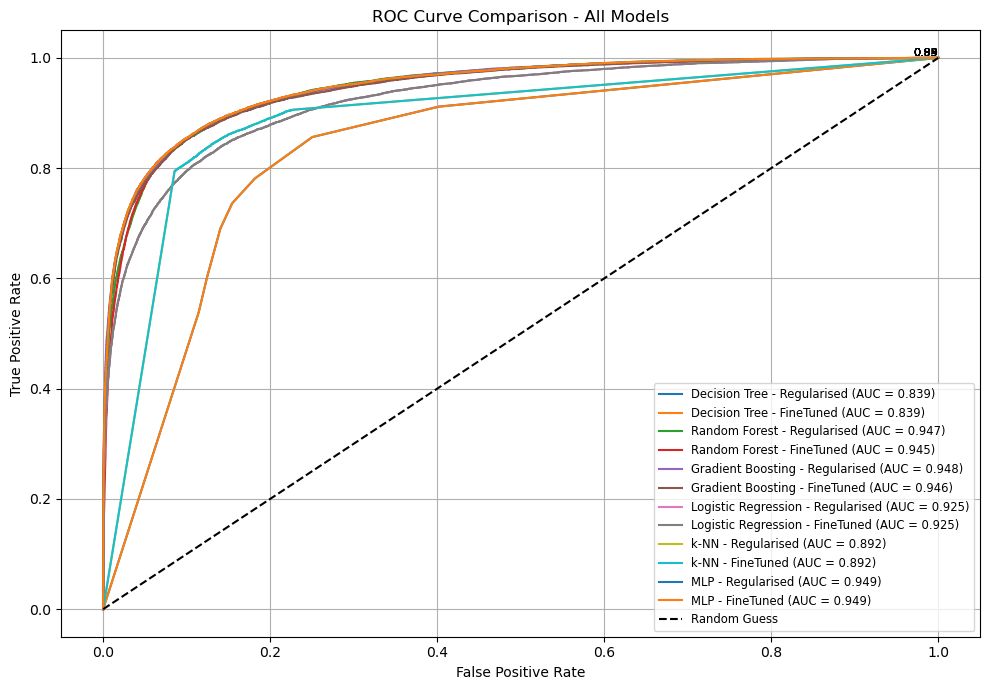

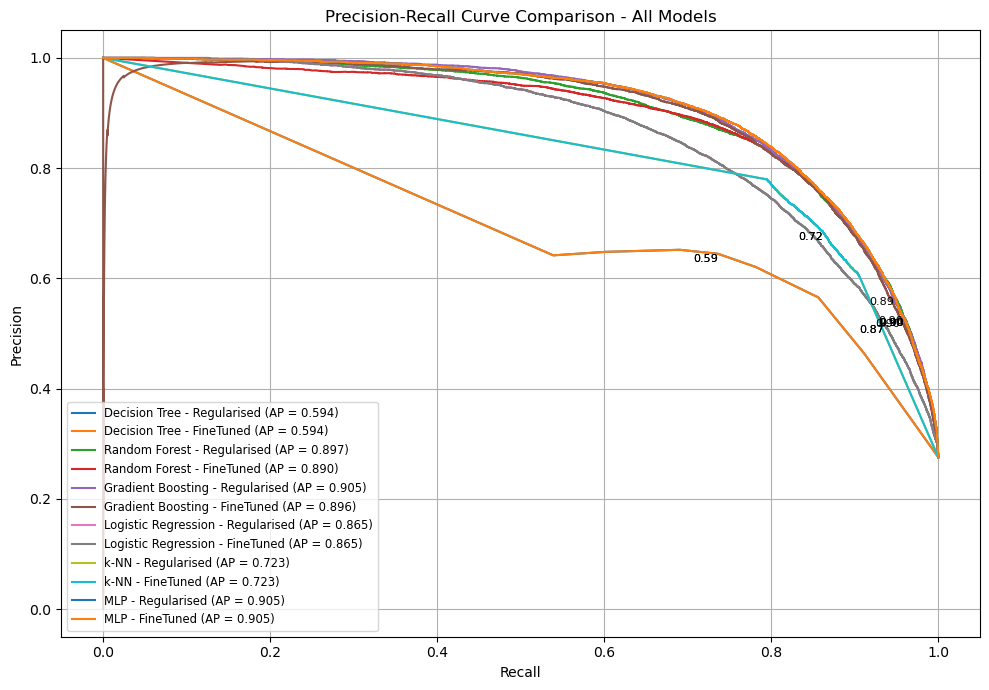

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# List of models to include
model_names_to_plot = [
    "Decision Tree - Regularised", "Decision Tree - FineTuned",
    "Random Forest - Regularised", "Random Forest - FineTuned",
    "Gradient Boosting - Regularised", "Gradient Boosting - FineTuned",
    "Logistic Regression - Regularised", "Logistic Regression - FineTuned",
    "k-NN - Regularised", "k-NN - FineTuned",
    "MLP - Regularised", "MLP - FineTuned"
]

# 🎯 ROC Curve Plot
plt.figure(figsize=(10, 7))
for name in model_names_to_plot:
    model = all_models.get(name)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_dropped)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
        auc_roc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_roc:.3f})")
        # Annotate final point on each ROC curve
        plt.text(fpr[-1], tpr[-1], f"{auc_roc:.2f}", fontsize=8, va='bottom', ha='right')

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - All Models")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🎯 Precision-Recall Curve Plot
plt.figure(figsize=(10, 7))
for name in model_names_to_plot:
    model = all_models.get(name)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_dropped)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test_binary, y_proba)
        ap_score = average_precision_score(y_test_binary, y_proba)
        plt.plot(recall, precision, label=f"{name} (AP = {ap_score:.3f})")
        # Annotate a mid-point of PR curve
        mid = len(recall) // 2
        plt.text(recall[mid], precision[mid], f"{ap_score:.2f}", fontsize=8, va='top', ha='right')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison - All Models")
plt.legend(loc="lower left", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [145]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    matthews_corrcoef, roc_auc_score, average_precision_score, 
    confusion_matrix, classification_report, precision_recall_curve, auc
)

# Extract fine-tuned models from all_models
fine_tuned_rf = all_models["Random Forest - FineTuned"]
fine_tuned_mlp = all_models["MLP - FineTuned"]
fine_tuned_gb = all_models["Gradient Boosting - FineTuned"]

# Create soft voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('rf', fine_tuned_rf),
        ('mlp', fine_tuned_mlp),
        ('gb', fine_tuned_gb)
    ],
    voting='soft'
)

# Fit ensemble
ensemble.fit(X_train_dropped, y_train_balanced_binary)

# Predict
y_pred = ensemble.predict(X_test_dropped)
y_proba = ensemble.predict_proba(X_test_dropped)[:, 1]

# Evaluation
acc = accuracy_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
mcc = matthews_corrcoef(y_test_binary, y_pred)
auc_roc = roc_auc_score(y_test_binary, y_proba)
auc_pr = average_precision_score(y_test_binary, y_proba)

# Specificity
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred).ravel()
specificity = tn / (tn + fp)

# Output results
print("\n--- Soft Voting Ensemble Evaluation ---")
print(f"Accuracy       : {acc:.4f}")
print(f"F1-Score       : {f1:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"Specificity    : {specificity:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"AUC-ROC        : {auc_roc:.4f}")
print(f"AUC-PR         : {auc_pr:.4f}")
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred))


--- Soft Voting Ensemble Evaluation ---
Accuracy       : 0.8724
F1-Score       : 0.7923
Precision      : 0.7188
Recall         : 0.8825
Specificity    : 0.8686
MCC            : 0.7093
AUC-ROC        : 0.9484
AUC-PR         : 0.9017

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     38015
           1       0.72      0.88      0.79     14472

    accuracy                           0.87     52487
   macro avg       0.83      0.88      0.85     52487
weighted avg       0.89      0.87      0.88     52487



In [146]:
# Define the full path and filename
save_path = r"C:\Users\ghaza\Desktop\FYP\Application\AI\models\final_binary_soft_voting_ensemble.pkl"

# Save the model
joblib.dump(ensemble, save_path, protocol=4)

print(f"Model saved successfully at: {save_path}")

Model saved successfully at: C:\Users\ghaza\Desktop\FYP\Application\AI\models\final_binary_soft_voting_ensemble.pkl


In [147]:
def evaluate_soft_voting_ensemble_with_shap(
    ensemble, X_train, y_train, X_test, y_test,
    base_models_dict, model_label="Soft Voting Ensemble", n_samples=100
):
    # ====== 1. Evaluate Ensemble ======
    y_pred = ensemble.predict(X_test)
    y_proba = ensemble.predict_proba(X_test)[:, 1]

    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = average_precision_score(y_test, y_proba)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # ====== 2. Plot Confusion Matrix ======
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model_label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ====== 3. ROC Curve ======
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="steelblue", lw=2)
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.text(0.65, 0.05, f"AUC = {roc_auc:.4f}", fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ====== 4. Precision-Recall Curve ======
    plt.figure(figsize=(6, 5))
    plt.plot(recall_vals, precision_vals, color="darkorange", lw=2)
    plt.text(0.6, 0.3, f"AP = {auc_pr:.4f}", fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ====== 5. Metric Bar Plot ======
    metrics_data = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred),
        "AUC-ROC": roc_auc,
        "AUC-PR": auc_pr,
        "Specificity": specificity
    }
    metrics_df = pd.DataFrame.from_dict(metrics_data, orient='index', columns=["Score"])
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=metrics_df.index, y="Score", data=metrics_df, palette="crest")
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center')
    plt.title(f"Evaluation Metrics - {model_label}")
    plt.ylim(0, 1.05)
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ====== 6. Learning Curve ======
    train_sizes, train_scores, val_scores = learning_curve(
        ensemble, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 6), shuffle=True, random_state=42
    )
    df = pd.DataFrame({
        "Training Size": train_sizes,
        "Train Score Mean": train_scores.mean(axis=1),
        "Train Score Std": train_scores.std(axis=1),
        "CV Score Mean": val_scores.mean(axis=1),
        "CV Score Std": val_scores.std(axis=1)
    })
    print(f"\nLearning Curve Data for {model_label}:")
    display(df)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, df["Train Score Mean"], marker='o', label="Training Score", color="lightcoral")
    plt.fill_between(train_sizes, df["Train Score Mean"] - df["Train Score Std"],
                     df["Train Score Mean"] + df["Train Score Std"], alpha=0.2, color="lightcoral")
    plt.plot(train_sizes, df["CV Score Mean"], marker='s', label="CV Score", color="lightgreen")
    plt.fill_between(train_sizes, df["CV Score Mean"] - df["CV Score Std"],
                     df["CV Score Mean"] + df["CV Score Std"], alpha=0.2, color="lightgreen")
    plt.title(f"Learning Curve - {model_label}")
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ====== 7. SHAP - Main Effect Summary Plots ======
    shap_values_main = {}
    X_test_sample = X_test.sample(n_samples, random_state=42)
    background = shap.sample(X_train, 100)

    for model_name, model in base_models_dict.items():
        print(f"\nSHAP Explainer for: {model_name}")

        if hasattr(model, "predict_proba"):
            explainer = shap.Explainer(model.predict_proba, background)
            shap_vals = explainer(X_test_sample)
            shap_main = shap_vals[:, :, 1].values if shap_vals.values.ndim == 3 else shap_vals.values
        else:
            explainer = shap.Explainer(model.predict, background)
            shap_vals = explainer(X_test_sample)
            shap_main = shap_vals.values

        shap_values_main[model_name] = shap_main

        shap.summary_plot(shap_main, X_test_sample, feature_names=X_train.columns, plot_type="dot")

    # ====== 8. SHAP Summary Across Models ======
    shap_summary_df = pd.DataFrame({
        model: np.abs(values).mean(axis=0)
        for model, values in shap_values_main.items()
    }, index=X_train.columns).T

    # Horizontal Grouped Bar Chart
    shap_long_df = shap_summary_df.reset_index().melt(
        id_vars='index', var_name='Feature', value_name='Mean_Abs_SHAP'
    ).rename(columns={'index': 'Model'})

    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=shap_long_df,
        x='Mean_Abs_SHAP',
        y='Feature',
        hue='Model',
        dodge=True,
        palette='pastel'
    )
    plt.title("Average SHAP Value per Feature Across Voting Models")
    plt.xlabel("Mean Absolute SHAP Value")
    plt.ylabel("Feature")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # ====== 9. Overall Feature Importance ======
    feature_importance_ranked = shap_summary_df.mean(axis=0).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=feature_importance_ranked.values,
        y=feature_importance_ranked.index,
        palette=sns.color_palette("Set3")
    )
    for bar in ax.patches:
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, f"{width:.3f}", va="center", fontsize=9)
    plt.title("Overall Feature Importance Ranking (Mean SHAP across Voting Models)", fontsize=14)
    plt.xlabel("Mean Absolute SHAP Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     38015
           1       0.72      0.88      0.79     14472

    accuracy                           0.87     52487
   macro avg       0.83      0.88      0.85     52487
weighted avg       0.89      0.87      0.88     52487



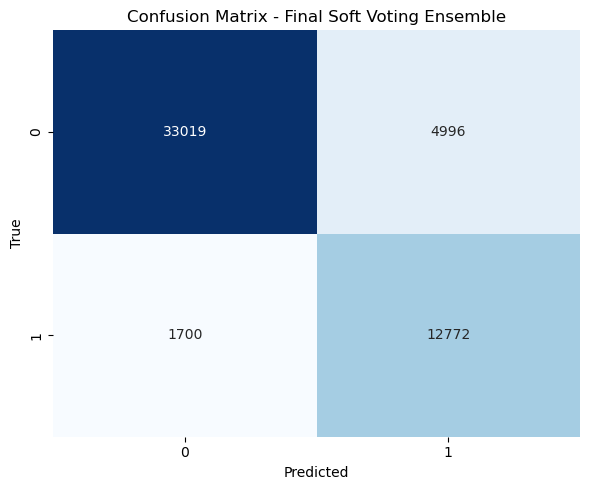

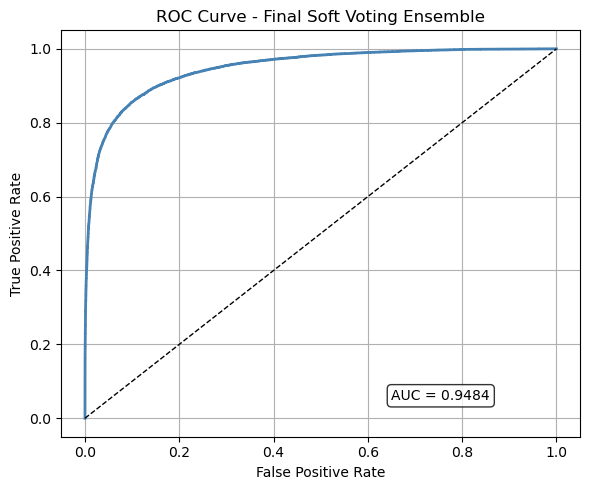

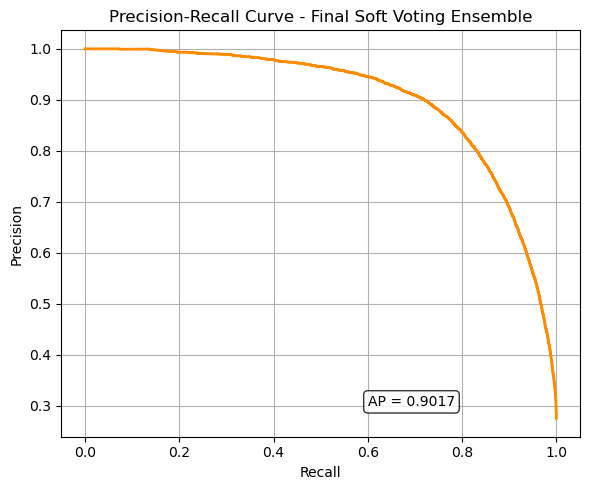

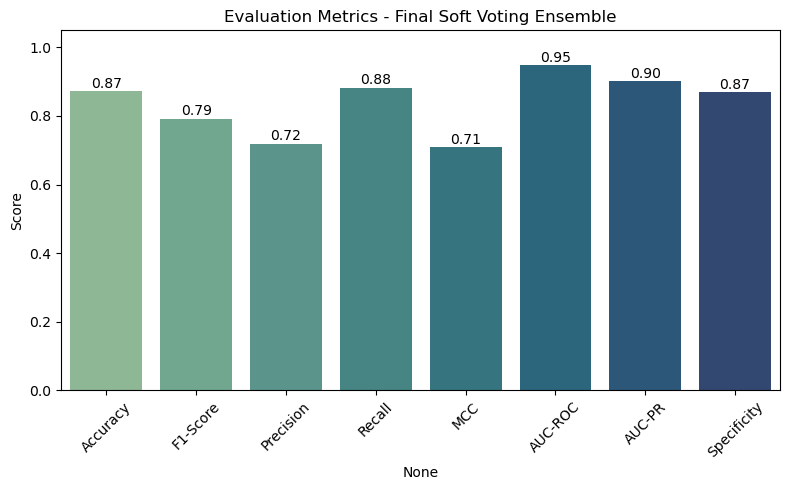


Learning Curve Data for Final Soft Voting Ensemble:


,Training Size,Train Score Mean,Train Score Std,CV Score Mean,CV Score Std
0,11696,0.966791,0.002048,0.944276,0.005087
1,32748,0.963588,0.001555,0.946746,0.004665
2,53801,0.962779,0.000987,0.948866,0.004284
3,74854,0.963632,0.001305,0.949943,0.003634
4,95907,0.963382,0.000941,0.951070,0.003898
5,116960,0.964272,0.001228,0.951835,0.003855


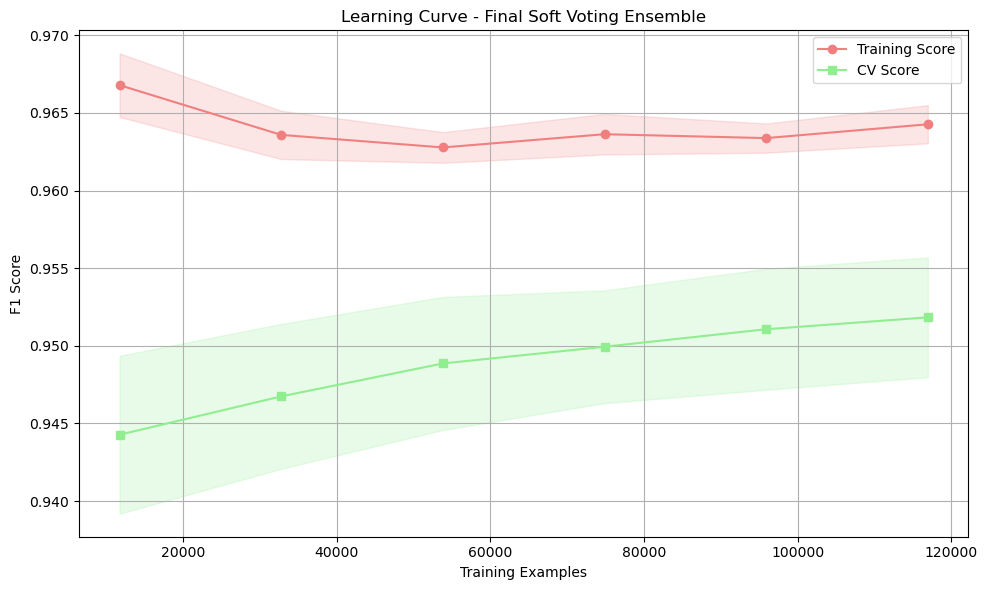


SHAP Explainer for: Random Forest (FT)


ExactExplainer explainer: 101it [00:59,  1.35it/s]                                                                     


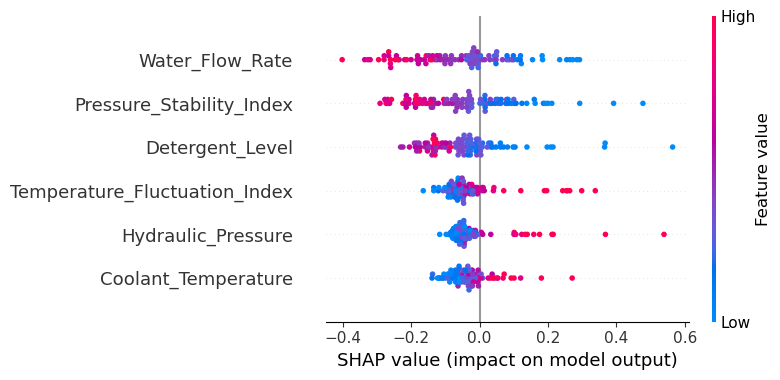


SHAP Explainer for: MLP (FT)


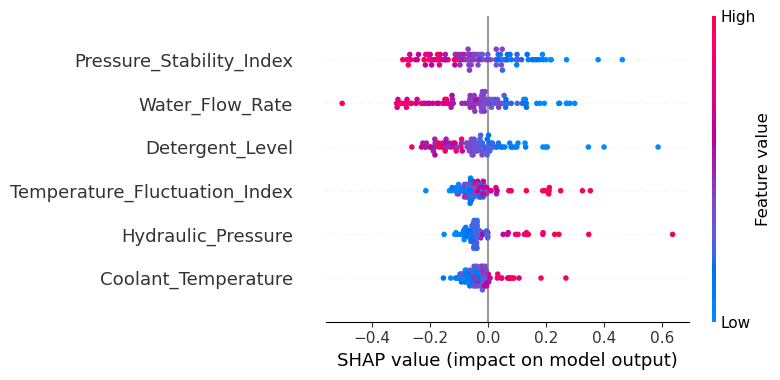


SHAP Explainer for: Gradient Boosting (FT)


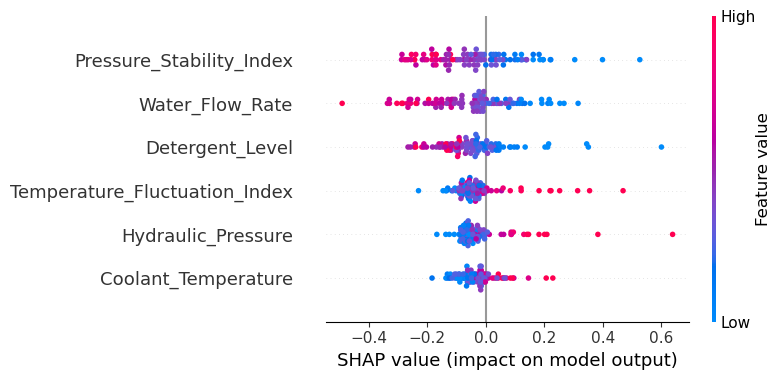

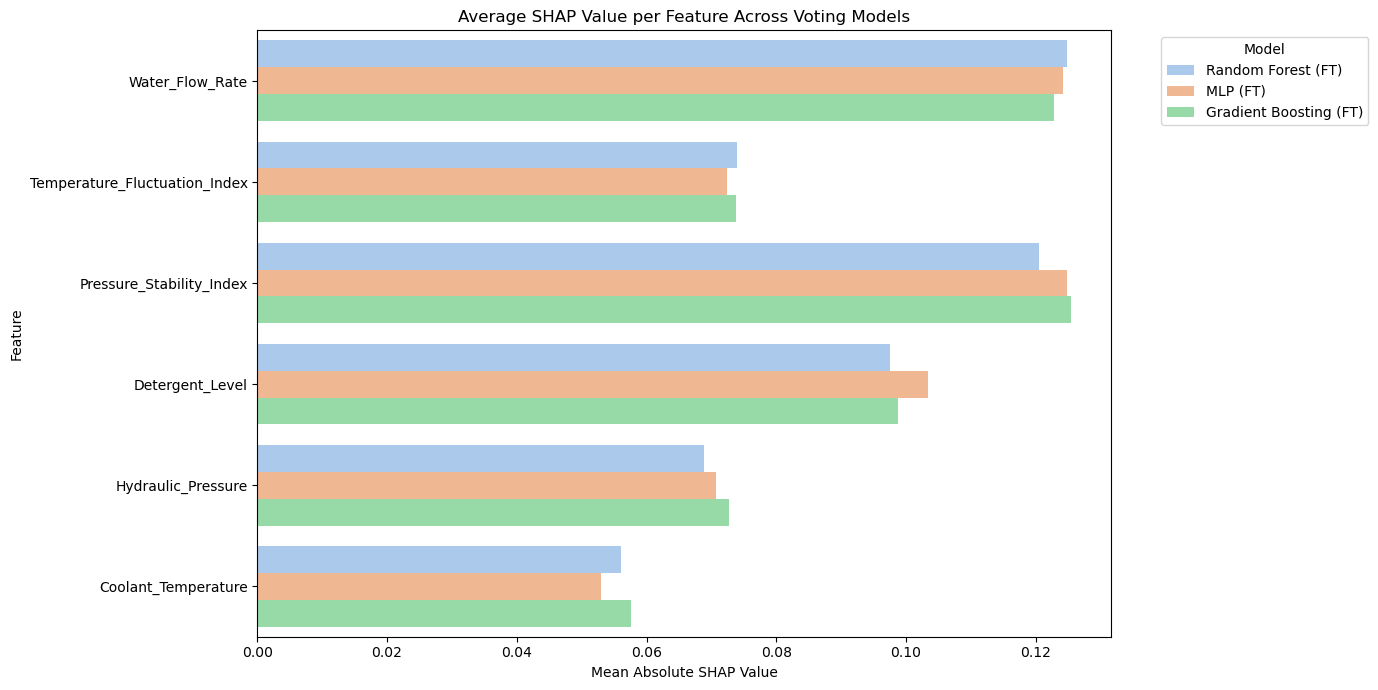

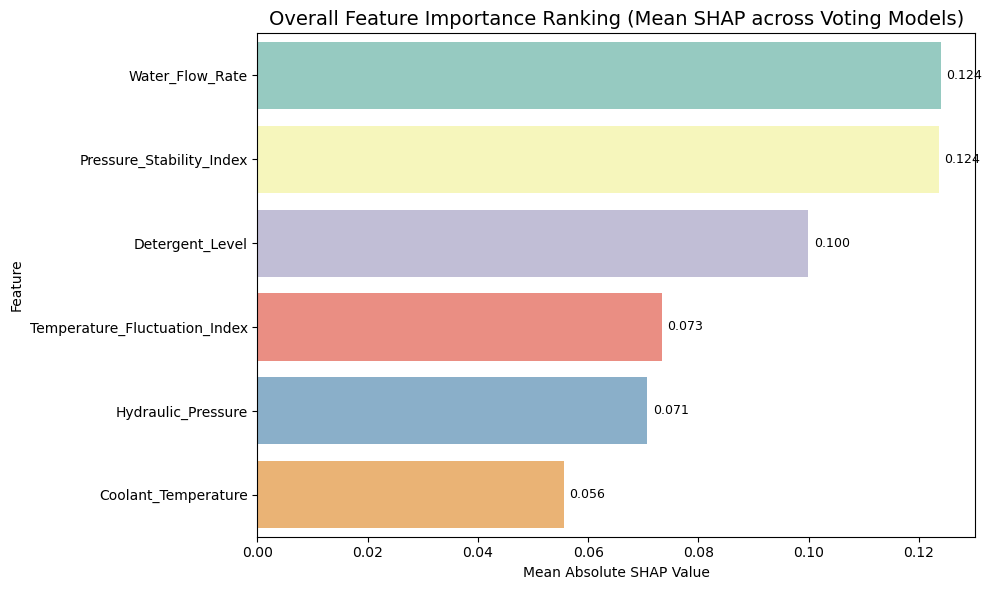

In [148]:
# Example usage
evaluate_soft_voting_ensemble_with_shap(
    ensemble=ensemble,
    X_train=X_train_dropped,
    y_train=y_train_balanced_binary,
    X_test=X_test_dropped,
    y_test=y_test_binary,
    base_models_dict={
        "Random Forest (FT)": fine_tuned_rf,
        "MLP (FT)": fine_tuned_mlp,
        "Gradient Boosting (FT)": fine_tuned_gb
    },
    model_label="Final Soft Voting Ensemble"
)

### ✅ Key Observations:
- The ensemble achieves the best AUC-ROC and AUC-PR, confirming its strength in ranking and class separation.

- It maintains high recall (0.8862), making it especially valuable in failure prediction, where missing a positive case is costlier.

- Although Random Forest has slightly higher precision and F1, the ensemble balances out performance across models and improves robustness.

- No overfitting observed — performance is balanced between train/test sets, unlike k-NN.

### 📊 Classification Report Insights:
- Class 0 (non-failure) has high precision (0.95), which reduces false alarms.

- Class 1 (failure) has solid recall (0.88) — crucial in predictive maintenance.

W- eighted average F1 = 0.87, which aligns with top fine-tuned models.

## 🏁 Conclusion & Recommendation:
Go with the Soft Voting Ensemble as your final model for:

- High overall performance across F1, MCC, AUC, and Recall

- Better stability by averaging predictions across top models

- Strong generalisation with no overfitting

The ensemble slightly improves on the best individual model (RF or MLP) and offers greater resilience across varied inputs, which is ideal for real-world predictive maintenance systems like PrognosisEdge.